# Import

In [1]:
from utils import *
from modules import *
import numpy as np 
import pandas as pd
from PIL import Image
import os
from os import listdir
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import rand_score,adjusted_rand_score
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from time import time


import warnings
warnings.filterwarnings("ignore")

# Fonctions

In [2]:
def evaluation(datas,labels,verbose=False):
    titles = ["X","Representation Latente","X_hat"]
    scores = []
    puritities = []
    rand_scores= []
    for i,data in enumerate(datas):

        shape = data.shape[1]
        nb_classes = len(np.unique(labels))

        neuro_i_1 = shape
        neuro_o_1 = shape // 2
        neuro_i_2 = shape // 2
        neuro_o_2 = shape // 4
        neuro_i_3 = shape // 4
        neuro_o_3 = nb_classes
        facteur_norma = 0.4
        plage_biais = (0,1)
        batch_size = 100
        epochs = 50


        facteur_norma = 0.8
        lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma)
        lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma)
        lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma)
        TanH = ModuleTanH()
        sigmoide = ModuleSigmoide()
        mseloss = MSELoss()
        CE = CrossEntropieLoss(nb_classes)
        softmax = SoftMax()


        network_layers = [lineaire_1,TanH,lineaire_2,TanH,lineaire_3,softmax]
        network = Sequentiel(network_layers)

        if verbose : print("Optimisation de : ",titles[i])
        opti = Optim(network,CE,1e-2)
        opti.SGD(data,labels,batch_size,epochs)

        score = opti.getNetwork().accuracy(data,labels) 
        scores.append(score)
        if verbose : print("Accuracy sur les images issues de l'auto encodeur",score)    
        
        kmeans = KMeans(n_clusters=10, random_state=0, max_iter=1000).fit(data)
        yhat = kmeans.labels_
        
        
        y_cluster_pred = np.zeros(len(data))
        indices = np.arange(len(data))

        for cluster in range(3):

            vals, counts = np.unique(labels[yhat == cluster], return_counts=True)
            val_maj = vals[np.argmax(counts)]

            y_cluster_pred[indices[yhat == cluster]] = val_maj
        
        purete = cluster_purity(labels,y_cluster_pred)
        puritities.append(purete)
        
        rs  = rand_score(labels,y_cluster_pre)
        rand_scores.append(rs)
        
        if verbose : 
            print("Pureté du clustering : ",purete)
            print("Rand score  : ",rs)
            print("Adjusted Rand Score : ",adjusted_rand_score(labels,y_cluster_pred))
            print()

        
        
    return scores,puritities,rand_scores
        
        
        
def optimisation_espace_latent(data,labels,dim_espace_latent_list,eps,verbose=False):
    
    nb_classes = len(np.unique(labels))
    n_samples = data.shape[0]
    scores = []
    puritities = []
    rand_scores= []
    
    
    for dim_espace_latent in dim_espace_latent_list:
        

        neuro_i_1 = 256
        neuro_o_1 = 160
        neuro_i_2 = 160
        neuro_o_2 = 120
        neuro_i_3 = 120
        neuro_o_3 = 60
        neuro_i_4 = 60
        neuro_o_4 = dim_espace_latent
        
        facteur_norma = 0.4
        plage_biais = (0,1)
        batch_size = 100
        epochs = 100
        nb_couches = 4


        facteur_norma = 0.8


        lineaire_1_enc = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma)
        lineaire_2_enc = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma)
        lineaire_3_enc = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma)
        lineaire_4_enc = ModuleLineaire(neuro_i_4 ,neuro_o_4 ,plage_biais,facteur_norma)

        lineaire_1_dec = ModuleLineaire(neuro_o_1 ,neuro_i_1 ,plage_biais,facteur_norma)
        lineaire_2_dec = ModuleLineaire(neuro_o_2 ,neuro_i_2 ,plage_biais,facteur_norma)
        lineaire_3_dec = ModuleLineaire(neuro_o_3 ,neuro_i_3 ,plage_biais,facteur_norma)
        lineaire_4_dec = ModuleLineaire(neuro_o_4 ,neuro_i_4 ,plage_biais,facteur_norma)

        TanH = ModuleTanH()
        sigmoide = ModuleSigmoide()
        BCE = BinaryCrossEntropie()


        network_layers = [lineaire_1_enc,TanH,lineaire_2_enc,TanH,lineaire_3_enc,TanH,lineaire_4_enc,TanH,
                          lineaire_4_dec,TanH,lineaire_3_dec,TanH,lineaire_2_dec,TanH,lineaire_1_dec,sigmoide]
        network = Sequentiel(network_layers)

        auto_encodeur_usps = AutoEncodeur(network,BCE)

        
        if verbose : print("Dimension espace latent : ",dim_espace_latent)
        
        auto_encodeur_usps.optimisation(data,labels,batch_size,epochs,eps,False)
        
        
        
        latent_repre = auto_encodeur_usps.encode(data)
        
        datas = [latent_repre]
        score,purete,rand_score = evaluation(datas,labels,verbose)
        scores.append(score)
        puritities.append(purete)
        rand_scores.append(rand_score)
        
    return scores , puritities , rand_scores



def create_auto_encodeur(X_train,output_dim, nb_couche_lin,activations, facteur_norma, plage_biais, batch_size, epochs,eps=1e-4):
    np.random.seed(42)
    input_dim = X_train.shape[1]
    n_samples = X_train.shape[0]
    neuro_in = [input_dim]
    neuro_out = []
    activations_enc = activations[0]
    activations_dec = activations[1]
    assert len(activations_enc) == nb_couche_lin and len(activations_dec) == nb_couche_lin
    for i in range(0,nb_couche_lin) : 
        neuro_out.append(neuro_in[::-1][0] // 2)
        neuro_in.append(neuro_out[::-1][0])
    neuro_out[-1] = output_dim
    neuro_in = neuro_in [:-1]
    modules_enc = []
    for i in range(nb_couche_lin):
        modules_enc.append(ModuleLineaire(neuro_in[i], neuro_out[i], plage_biais, facteur_norma))
        modules_enc.append(activations_enc[i])
        

    modules_dec = []
    #neuro_out = neuro_out[::-1]
    neuro_in = neuro_in[::-1]
    neuro_out = neuro_out[::-1]
    for i in range(nb_couche_lin):
        modules_dec.append(ModuleLineaire(neuro_out[i], neuro_in[i], plage_biais, facteur_norma))
        modules_dec.append(activations_dec[i])
        
    
    network = Sequentiel(modules_enc + modules_dec)
    BCE = BinaryCrossEntropie()
    auto_encodeur_usps = AutoEncodeur(network, BCE)
    auto_encodeur_usps.optimisation(X_train, X_train, batch_size, epochs,eps)
    
    return auto_encodeur_usps




def optimisation_nb_layers(X_train,Y_train,liste_layers,output_dim,facteur_norma,plage_biais,batch_size,epochs,random_activ):
    shape = X_train.shape[1]
    TanH = ModuleTanH()
    sigmoide = ModuleSigmoide()
    activ = np.array([TanH,sigmoide])
    scores = []
    act_s = []
    opt_s = []
    
    
  
    for nb_layer in liste_layers:
        print("Optimisation nb_layer  : ",nb_layer)
        
        if random_activ:
            np.random.seed(42)
            activations_enc = np.random.randint(0,2,size=nb_layer)
            activations_dec = np.random.randint(0,2,size=nb_layer)

            activ_enc = activ[activations_enc]
            activ_dec = activ[activations_dec]

            activ_layer = [activ_enc,activ_dec]
        else:
            activations_enc = [TanH for _ in range(nb_layer)]
            activations_dec = [TanH for _ in range(nb_layer - 1)]
            activations_dec.append(sigmoide)
            activ_layer = [activations_enc,activations_dec]
        
        opt = create_auto_encodeur(X_train,output_dim, nb_layer,activ_layer, facteur_norma, plage_biais, batch_size, epochs,eps=1e-4)
        
        latent_repre = opt.encode(X_train)
        X_train_hat = opt.decode(latent_repre)
        
        scores.append(evaluation([X_train_hat],Y_train)[0])
        act_s.append(activ_layer)
        opt_s.append(opt)
        
        
    return scores,act_s,opt_s




def optimisation_network(X_train,Y_train,X_test,Y_test,liste_layers,liste_dim_espace_latent,batch_size,epochs,random_activ=False,verbose=False):
    
    facteur_norma = 0.8
    plage_biais = (0,1)
    resultat_train = {}
    scores_test = []
    for output_dim in liste_dim_espace_latent :
        print("Optimisation de la dimension de l'espace latent : ",output_dim)
        resultat_train["Espace latent " +str(output_dim)] = optimisation_nb_layers(X_train,Y_train,liste_layers,output_dim,facteur_norma,plage_biais,batch_size,epochs,random_activ)
        print()
        l = []
        for i,nb_layer in enumerate(liste_layers):
            opt = resultat_train['Espace latent '+str(output_dim)][2][i]
            latent_repre = opt.encode(X_test)
            X_test_hat = opt.decode(latent_repre)

            l.append(evaluation([X_test_hat],Y_test)[0])
        scores_test.append(l)
    
    LDS = ["LD"+str(output_dim) for output_dim in liste_dim_espace_latent]
    
    if verbose:
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)
        for i, output_dim in enumerate(liste_dim_espace_latent) :
            
            scores = resultat_train['Espace latent '+str(output_dim)][0]
            plt.title("Accuracy du train selon l'espace latent ")
            plt.xlabel("nombre de layers")
            plt.ylabel("accuracy")
            plt.plot(liste_layers,scores)
        plt.legend(LDS)
        
        
        plt.subplot(1,2,2)
            
        for i, output_dim in enumerate(liste_dim_espace_latent) :

            activs = resultat_train['Espace latent '+str(output_dim)][1]
            plt.title("Accuracy du train selon l'espace latent")
            plt.xlabel("nombre de layers")
            plt.ylabel("accuracy")
            plt.plot(liste_layers,scores_test[i])

        plt.legend(LDS)

        plt.show()
        
        
    maximums = []
    for i, output_dim in enumerate(liste_dim_espace_latent) :
        
        scores , activations ,_ = resultat_train['Espace latent '+str(output_dim)]
        maximums.append(np.max(scores))
        
    
    dim_espace_latent_optimal = liste_dim_espace_latent[np.argmax(maximums)]
    scores = resultat_train['Espace latent '+str(dim_espace_latent_optimal)][0]
    nb_layer_optimal = liste_layers[np.argmax(scores)]
    nb_layer_optimal_ind = np.argmax(scores)
    activ_optimal = resultat_train['Espace latent '+str(dim_espace_latent_optimal)][1][nb_layer_optimal_ind]
    
    network_optimal = create_auto_encodeur(X_train,dim_espace_latent_optimal, nb_layer_optimal,activ_optimal, facteur_norma, plage_biais, batch_size, epochs)
    
    print("Auto encodeur optimal : ")
    print("Nombre layer optimal : ",nb_layer_optimal)
    print("Dimension optimale de l'espace latent : ",dim_espace_latent_optimal)
    print("Fonctions d'activation prises : ")
    print([str(a) for a in activ_optimal[0]])
    print([str(a) for a in activ_optimal[1]])
        
    return network_optimal


# Probleme Lineaire

### Probleme lineaire dont la frontiere de decision va passer par l'origine

In [3]:
# definir un jeu de données lineairement separable 
seed = 42
np.random.seed(seed)
pos_cen = (-3, -3)
pos_sig = [[1, 4], [4, 1]]

neg_cen = (3, 3)
neg_sig = [[1, 5], [4, 1]]
data_train,labels_train = genere_dataset_gaussian(pos_cen,pos_sig,neg_cen,neg_sig,100,-1,1)
labels_train = labels_train.reshape(-1,1)

pos_cen = (-3, -3)
pos_sig = [[2, 2], [3, 2]]

neg_cen = (3, 3)
neg_sig = [[1, 2], [4, 2]]
data_test,labels_test = genere_dataset_gaussian(pos_cen,pos_sig,neg_cen,neg_sig,100,-1,1)
labels_test = labels_test.reshape(-1,1)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1043.00it/s]


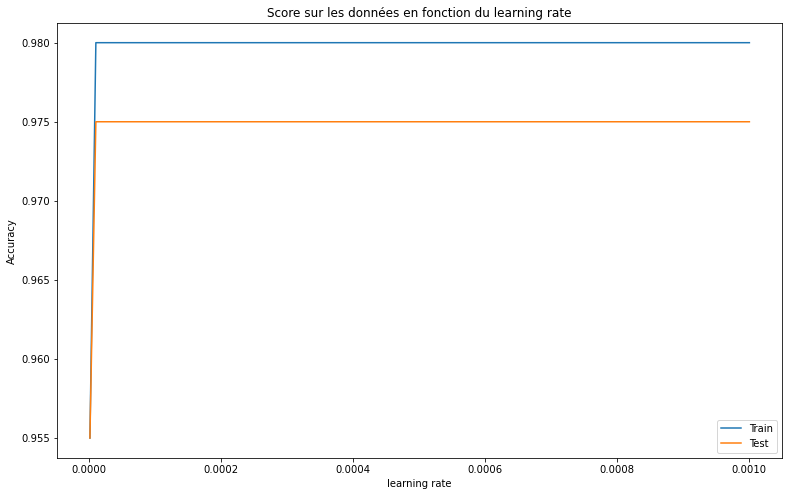

Learning rate optimal  :  0.001


In [4]:
# definir un reseau linaire
facteur_norma = 0.4
plage_biais = (0,1)
np.random.seed(96)

neuro_i = 2
neuro_o = 1
batch_size = 20
epochs = 1000
rates = np.array([1e-3,1e-4,1e-5,1e-6])
scores_tr = []
scores_te = []

for eps in rates:

    lineaire = ModuleLineaire(neuro_i,neuro_o,plage_biais,facteur_norma)
    mseloss = MSELoss()
    network_layers = [lineaire]
    network = Sequentiel(network_layers)

    opti = Optim(network,mseloss,eps)
    opti.SGD(data_train,labels_train,batch_size,epochs)
    scores_tr.append(opti.getNetwork().accuracy(data_train,labels_train))
    scores_te.append(opti.getNetwork().accuracy(data_test,labels_test))
    
plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction du learning rate")
plt.xlabel("learning rate")
plt.ylabel("Accuracy")
plt.plot(rates,scores_tr)
plt.plot(rates,scores_te)
plt.legend(["Train","Test"])
plt.show()

eps_optimal = rates[np.argmax(scores_te)]
print("Learning rate optimal  : ",eps_optimal)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1077.51it/s]


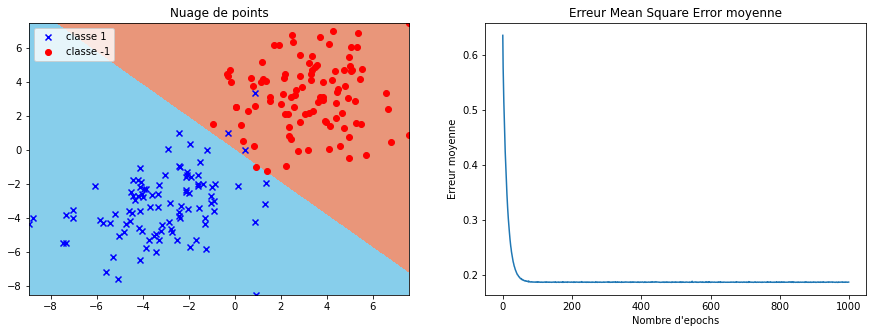

Accuracy  :  0.98


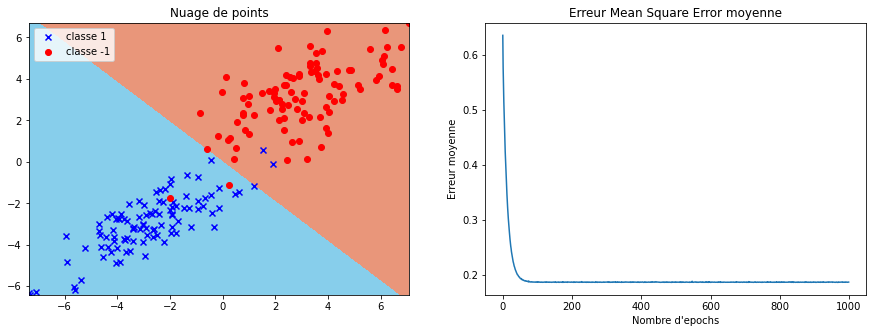

Accuracy  :  0.975


In [6]:
# definir un reseau linaire
facteur_norma = 0.4
plage_biais = (0,1)
neuro_i = 2
neuro_o = 1
batch_size = 20
epochs = 1000

lineaire = ModuleLineaire(neuro_i,neuro_o,plage_biais,facteur_norma)
mseloss = MSELoss()
network_layers = [lineaire]
network = Sequentiel(network_layers)

opti = Optim(network,mseloss,1e-4)
opti.SGD(data_train,labels_train,batch_size,epochs)
opti.affichage(data_train,labels_train)

opti.affichage(data_test,labels_test)

### Probleme lineaire separable uniquement avec introduction du biais

In [ ]:
# definir un jeu de données lineairement separable 
seed = 42
np.random.seed(seed)
pos_cen = (3, 3)
pos_sig = [[1, 16], [16, 1]]

neg_cen = (13, 13)
neg_sig = [[1, 15], [16, 1]]
data_train,labels_train = genere_dataset_gaussian(pos_cen,pos_sig,neg_cen,neg_sig,100,-1,1)
labels_train = labels_train.reshape(-1,1)


pos_cen = (3, 3)
pos_sig = [[2, 14], [16, 3]]
neg_cen = (13, 13)
neg_sig = [[1, 13], [17, 2]]
data_test,labels_test = genere_dataset_gaussian(pos_cen,pos_sig,neg_cen,neg_sig,100,-1,1)
labels_test = labels_test.reshape(-1,1)

In [5]:
# definir un reseau linaire
np.random.seed(96)
facteur_norma = 0.4
plage_biais = (0,1)
neuro_i = 2
neuro_o = 1
batch_size = 50
epochs = 1000
rates = np.array([1e-4,1e-5,1e-6,1e-7])
scores_tr = []
scores_te = []

for eps in rates:

    lineaire = ModuleLineaire(neuro_i,neuro_o,plage_biais,facteur_norma)
    mseloss = MSELoss()
    network_layers = [lineaire]
    network = Sequentiel(network_layers)

    opti = Optim(network,mseloss,eps)
    opti.SGD(data_train,labels_train,batch_size,epochs)
    scores_tr.append(opti.getNetwork().accuracy(data_train,labels_train))
    scores_te.append(opti.getNetwork().accuracy(data_test,labels_test))

plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction du learning rate")
plt.xlabel("learning rate")
plt.ylabel("Accuracy")
plt.plot(rates,scores_tr)
plt.plot(rates,scores_te)
plt.legend(["Train","Test"])
plt.show()

eps_optimal = rates[np.argmax(scores_te)]
print("Learning rate optimal  : ",eps_optimal)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]


AttributeError: 'ModuleLineaire' object has no attribute '_parameters'

In [6]:
# definir un reseau linaire
facteur_norma = 0.4
plage_biais = (0,1)
neuro_i = 2
neuro_o = 1
batch_size = 20
epochs = 1000

lineaire = ModuleLineaire(neuro_i,neuro_o,plage_biais,facteur_norma)
mseloss = MSELoss()
network_layers = [lineaire]
network = Sequentiel(network_layers)

opti = Optim(network,mseloss,eps_optimal)
opti.SGD(data_train,labels_train,batch_size,epochs)
opti.affichage(data_train,labels_train)

opti.affichage(data_test,labels_test)

NameError: name 'eps_optimal' is not defined

# Non Lineaire

### Definir un jeu de données de type XOR qui non separable lineairement 

In [9]:
# definir un jeu de données XOR

seed = 42
np.random.seed(seed)
data_xor_train , labels_xor_train = create_XOR(200,0.2)

data_xor_test , labels_xor_test = create_XOR(200,0.3)

In [7]:
neuro_i_1 = 2
neuro_o_1 = 4
neuro_i_2 = 4
neuro_o_2 = 1

plage_biais = (0,1)
batch_size = 50
epochs = 1000
facteur_norma = 0.8

rates = np.array([1e-2,1e-3,1e-4,1e-5])
scores_tr = []
scores_te = []

for eps in rates:
    lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma)
    lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma)
    TanH = ModuleTanH()
    sigmoide = ModuleSigmoide()
    mseloss = MSELoss()


    network_layers = [lineaire_1,TanH,lineaire_2,sigmoide]
    network = Sequentiel(network_layers)


    opti = Optim(network,mseloss,eps)
    opti.SGD(data_xor_train,labels_xor_train,batch_size,epochs)
    scores_tr.append(opti.getNetwork().accuracy(data_xor_train,labels_xor_train))
    scores_te.append(opti.getNetwork().accuracy(data_xor_test,labels_xor_test))

plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction du learning rate")
plt.xlabel("learning rate")
plt.ylabel("Accuracy")
plt.plot(rates,scores_tr)
plt.plot(rates,scores_te)
plt.legend(["Train","Test"])
plt.show()

eps_optimal = rates[np.argmax(scores_te)]
print("Learning rate optimal  : ",eps_optimal)

NameError: name 'data_xor_train' is not defined

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 317.02it/s]


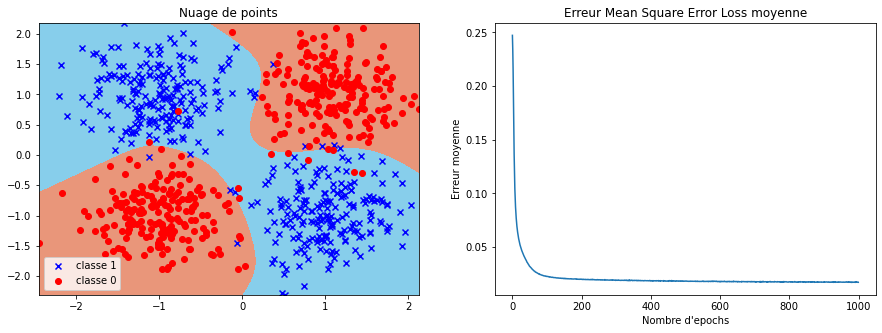

Accuracy  :  0.9775


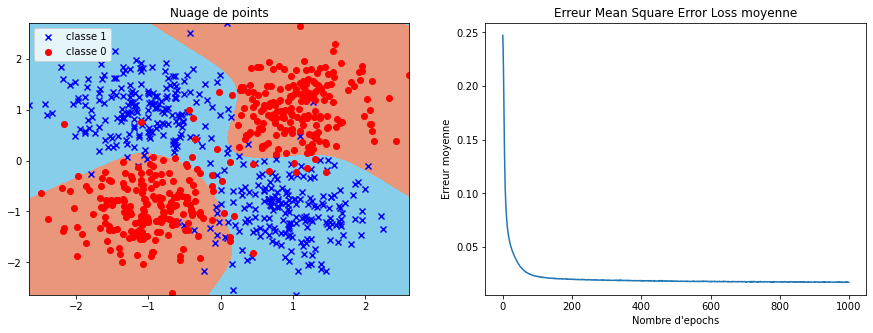

Accuracy  :  0.93625


In [11]:
neuro_i_1 = 2
neuro_o_1 = 4
neuro_i_2 = 4
neuro_o_2 = 1
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 1000


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma)
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma)
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()


network_layers = [lineaire_1,TanH,lineaire_2,sigmoide]
network = Sequentiel(network_layers)


opti = Optim(network,mseloss,eps_optimal)
opti.SGD(data_xor_train,labels_xor_train,batch_size,epochs)
opti.affichage(data_xor_train,labels_xor_train)
opti.affichage(data_xor_test,labels_xor_test)

### Definir un jeu de données de type DIRAC qui non separable lineairement 

In [12]:
# definir un jeu de données XOR

seed = 42
np.random.seed(seed)
data_dirac_train , label_dirac_train = create_data_dirac(200,0.1)
data_dirac_test , label_dirac_test = create_data_dirac(200,0.2)

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 212.29it/s]


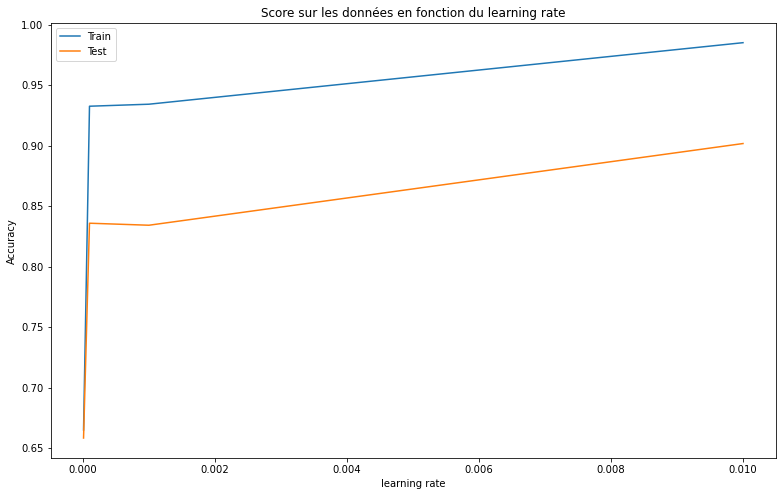

Learning rate optimal  :  0.01


In [13]:
neuro_i_1 = 2
neuro_o_1 = 4
neuro_i_2 = 4
neuro_o_2 = 1

plage_biais = (-1,10)
batch_size = 50
epochs = 1000
facteur_norma = 0.8

rates = np.array([1e-2,1e-3,1e-4,1e-5])

scores_tr = []
scores_te = []

for eps in rates:
    lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma)
    lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma)
    TanH = ModuleTanH()
    sigmoide = ModuleSigmoide()
    mseloss = MSELoss()


    network_layers = [lineaire_1,TanH,lineaire_2,sigmoide]
    network = Sequentiel(network_layers)


    opti = Optim(network,mseloss,eps)
    opti.SGD(data_dirac_train,label_dirac_train,batch_size,epochs)
    scores_tr.append(opti.getNetwork().accuracy(data_dirac_train,label_dirac_train))
    scores_te.append(opti.getNetwork().accuracy(data_dirac_test,label_dirac_test))

plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction du learning rate")
plt.xlabel("learning rate")
plt.ylabel("Accuracy")
plt.plot(rates,scores_tr)
plt.plot(rates,scores_te)
plt.legend(["Train","Test"])
plt.show()

eps_optimal = rates[np.argmax(scores_te)]
print("Learning rate optimal  : ",eps_optimal)

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 206.82it/s]


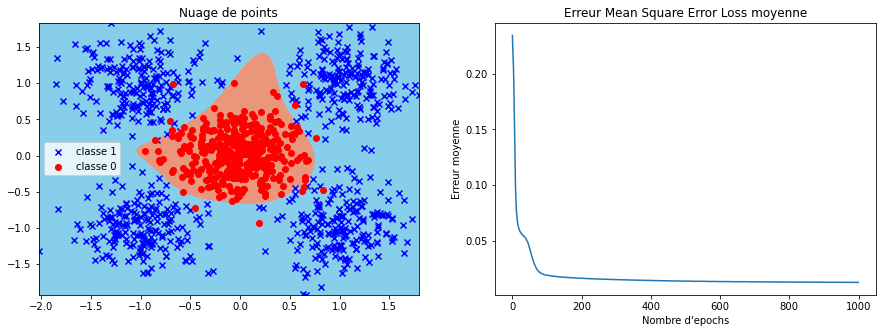

Accuracy  :  0.9866666666666667


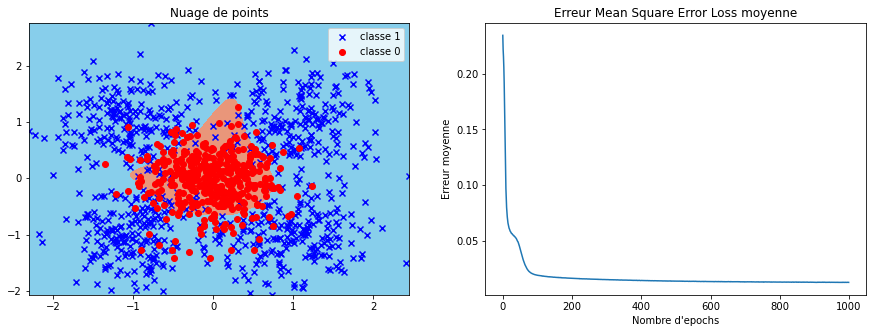

Accuracy  :  0.8975


In [14]:
neuro_i_1 = 2
neuro_o_1 = 4
neuro_i_2 = 4
neuro_o_2 = 1
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 1000


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma)
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma)
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()


network_layers = [lineaire_1,TanH,lineaire_2,sigmoide]
network = Sequentiel(network_layers)


opti = Optim(network,mseloss,eps_optimal)
opti.SGD(data_dirac_train,label_dirac_train,batch_size,epochs)
opti.affichage(data_dirac_train,label_dirac_train)
opti.affichage(data_dirac_test,label_dirac_test)

# Multi Classes

### import des données USPS

In [3]:
import pickle as pkl
data = pkl.load(open("data/usps.pkl",'rb'))

X_train = data["X_train"]
Y_train = data["Y_train"]
X_test = data["X_test"]
Y_test = data["Y_test"]

### Affichage en t-SNE des données

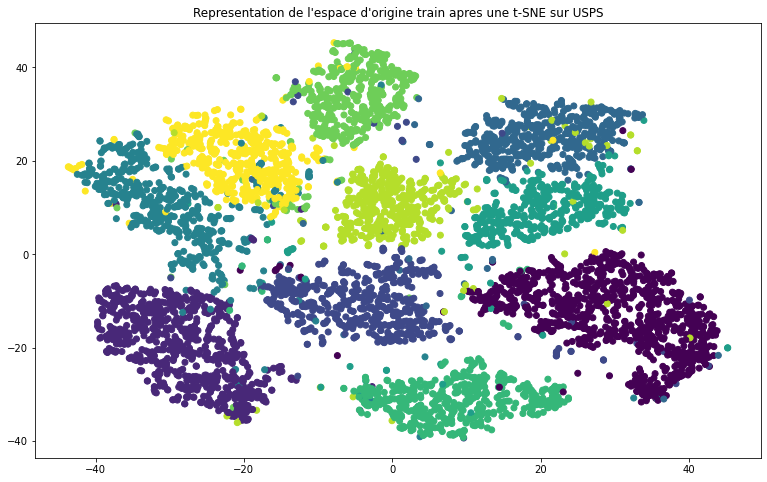

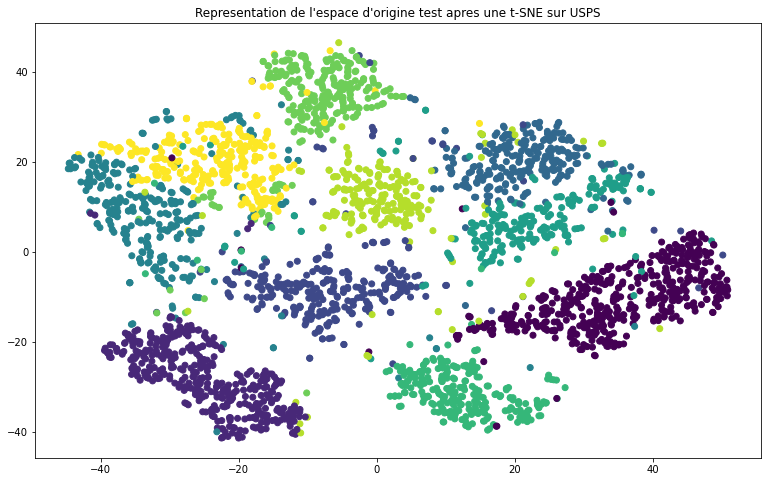

In [16]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)


repre_2D = tsne.fit_transform(X_train)

plt.figure(figsize=(13,8))
plt.title("Representation de l'espace d'origine train apres une t-SNE sur USPS")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)
plt.show()

repre_2D = tsne.fit_transform(X_test)

plt.figure(figsize=(13,8))
plt.title("Representation de l'espace d'origine test apres une t-SNE sur USPS")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_test)
plt.show()

### definition d'une architecture 

100%|███████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s]


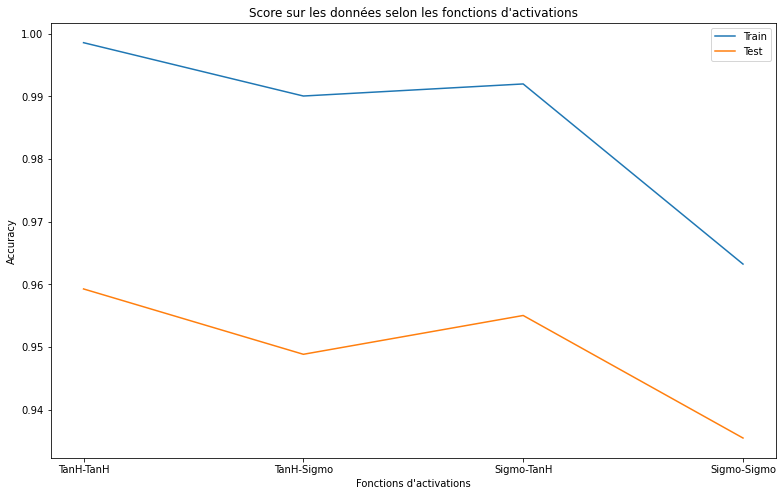

In [17]:
np.random.seed(42)
nb_classes = len(np.unique(Y_train))
n_samples = X_train.shape[0]

neuro_i_1 = 256
neuro_o_1 = 120
neuro_i_2 = 120
neuro_o_2 = 60
neuro_i_3 = 60
neuro_o_3 = 10
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 20
epochs = 50

scores_tr = []
scores_te = []
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()
CE = CrossEntropieLoss(nb_classes)
softmax = SoftMax()
activations = [[TanH,TanH],[TanH,sigmoide],[sigmoide,TanH],[sigmoide,sigmoide]]
fonctions = ["TanH-TanH","TanH-Sigmo","Sigmo-TanH","Sigmo-Sigmo"]

for activa in activations:
    lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma)
    lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma)
    lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma)

    network_layers = [lineaire_1,activa[0],lineaire_2,activa[1],lineaire_3,softmax]
    network = Sequentiel(network_layers)

    opti = Optim(network,CE,1e-2)
    opti.SGD(X_train,Y_train,batch_size,epochs)
    scores_tr.append(opti.getNetwork().accuracy(X_train,Y_train))
    scores_te.append(opti.getNetwork().accuracy(X_test,Y_test)) 
    
    
plt.figure(figsize=(13,8))
plt.title("Score sur les données selon les fonctions d'activations")
plt.xlabel("Fonctions d'activations")
plt.ylabel("Accuracy")
plt.plot(fonctions,scores_tr)
plt.plot(fonctions,scores_te)
plt.legend(["Train","Test"])
plt.show()

- On remarque qu'en mettant une sigmoide pour la premiere couche et une autre sigmoide pour la deuxieme couche donne des resultats plus interessants vu que la generalisation sur le probleme est plus grande (97% train , 93% test) par rapport aux autres combinaisons de fonction d'activations.

### Evaluation du reseau optimal

100%|███████████████████████████████████████████| 50/50 [00:25<00:00,  1.98it/s]


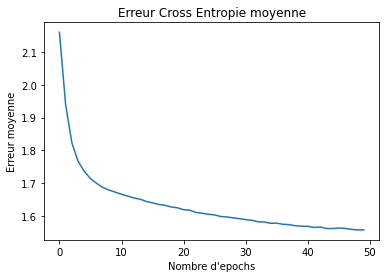

Accuracy  :  0.9733504575373254
Accuracy sur le train :  0.9733504575373254
Accuracy sur le test :  0.9341805148256761


In [5]:
np.random.seed(42)
nb_classes = len(np.unique(Y_train))
n_samples = X_train.shape[0]

neuro_i_1 = 256
neuro_o_1 = 120
neuro_i_2 = 120
neuro_o_2 = 60
neuro_i_3 = 60
neuro_o_3 = 10
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 50


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma)
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma)
lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma)
TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()
CE = CrossEntropieLoss(nb_classes)
softmax = SoftMax()


network_layers = [lineaire_1,sigmoide,lineaire_2,sigmoide,lineaire_3,softmax]
network = Sequentiel(network_layers)

opti = Optim(network,CE,1e-2)
opti.SGD(X_train,Y_train,batch_size,epochs)
opti.affichage(X_train,Y_train)


print("Accuracy sur le train : ",opti.getNetwork().accuracy(X_train,Y_train))
print("Accuracy sur le test : ",opti.getNetwork().accuracy(X_test,Y_test))


net_to_graph(network, net_name="networks_images/network_MC_USPS", horizontal=True)


In [7]:
nb_classes = 10

Y_pred = opti.getNetwork().predict(X_train,nb_classes)

kmeans = KMeans(n_clusters=nb_classes, random_state=0, max_iter=1000).fit(X_train)
yhat = kmeans.labels_

y_cluster_pred = np.zeros(len(X_train))
indices = np.arange(len(X_train))

for cluster in range(nb_classes):

    vals, counts = np.unique(Y_train[yhat == cluster], return_counts=True)
    val_maj = vals[np.argmax(counts)]

    y_cluster_pred[indices[yhat == cluster]] = val_maj

    
y_cluster_pred = np.array(y_cluster_pred.astype("int"))


print("TRAIN\n")
print("Purete du clustering de Kmeans sur les labels USPS : ",cluster_purity(Y_train,y_cluster_pred))
print("Purete du clustering de Kmeans sur les labels prédits par le reseau optimal : ",cluster_purity(Y_pred,y_cluster_pred))

print()

print("Rand_score du clustering de Kmeans sur les labels USPS : ",rand_score(Y_train,y_cluster_pred))
print("Rand_score du clustering de Kmeans sur les labels prédits par le reseau optimal : ",rand_score(Y_pred,y_cluster_pred))



print("--------------------------------------------")


Y_pred = opti.getNetwork().predict(X_test,nb_classes)

kmeans = KMeans(n_clusters=10, random_state=0, max_iter=1000).fit(X_test)
yhat = kmeans.labels_

y_cluster_pred = np.zeros(len(X_test))
indices = np.arange(len(X_test))

for cluster in range(nb_classes):

    vals, counts = np.unique(Y_test[yhat == cluster], return_counts=True)
    val_maj = vals[np.argmax(counts)]

    y_cluster_pred[indices[yhat == cluster]] = val_maj

y_cluster_pred = np.array(y_cluster_pred.astype("int"))

print("\nTEST\n")
print("Purete du clustering de Kmeans sur les labels USPS : ",cluster_purity(Y_test,y_cluster_pred))
print("Purete du clustering de Kmeans sur les labels prédits par le reseau optimal : ",cluster_purity(y_cluster_pred,Y_pred,nb_classes))

print()

print("Rand_score du clustering de Kmeans sur les labels USPS : ",rand_score(Y_test,y_cluster_pred))
print("Rand_score du clustering de Kmeans sur les labels prédits par le reseau optimal : ",rand_score(y_cluster_pred,Y_pred))



TRAIN

Purete du clustering de Kmeans sur les labels USPS :  0.7389629153957297
Purete du clustering de Kmeans sur les labels prédits par le reseau optimal :  0.7471504254294429

Rand_score du clustering de Kmeans sur les labels USPS :  0.921614801713204
Rand_score du clustering de Kmeans sur les labels prédits par le reseau optimal :  0.923764555392954
--------------------------------------------

TEST

Purete du clustering de Kmeans sur les labels USPS :  0.7282502443792767
Purete du clustering de Kmeans sur les labels prédits par le reseau optimal :  0.7865754317367221

Rand_score du clustering de Kmeans sur les labels USPS :  0.9186608907768011
Rand_score du clustering de Kmeans sur les labels prédits par le reseau optimal :  0.9220541623494056


- On remarque que les metrics de clusterig ( purete et rand score ) donnent pratiquement les meme resultats sur les labels d'origine des données USPS et sur les labels predits par le reseau optimisé , ce qui prouve que le reseau a bien ete optimisé et a ete bien generale sur les données de test.

# Alphabets

In [36]:
import pandas as pd

letters_data = pd.read_csv("data/digital_letters.csv")


letters_data = np.array(letters_data)
letters_labels = cara_to_int(letters_data[:,-1])
letters_data = letters_data[:,1:-1]

letters_data = letters_data.astype('float')
letters_data = normalisation(letters_data)

indices = np.random.permutation(letters_data.shape[0])

nb_sample = int(letters_data.shape[0]*0.7)

X_train_letters = letters_data[indices[:nb_sample]]
Y_train_letters = letters_labels[indices[:nb_sample]]
X_test_letters = letters_data[indices[nb_sample:]]
Y_test_letters = letters_labels[indices[nb_sample:]]

In [ ]:
scores_tr = []
scores_te = []
rates = [1e-2,1e-3,1e-4,1e-5]
for rate in rates:
    
    np.random.seed(42)
    nb_classes = len(np.unique(Y_train_letters))
    n_samples = X_train_letters.shape[0]

    neuro_i_1 = 784
    neuro_o_1 = 600
    neuro_i_2 = 600
    neuro_o_2 = 450
    neuro_i_3 = 450
    neuro_o_3 = 300
    neuro_i_4 = 300
    neuro_o_4 = 150
    neuro_i_5 = 150
    neuro_o_5 = 70
    neuro_i_6 = 70
    neuro_o_6 = 26


    facteur_norma = 0.4
    plage_biais = (0,1)
    batch_size = 50
    epochs = 100


    facteur_norma = 0.8
    lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma)
    lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma)
    lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma)
    lineaire_4 = ModuleLineaire(neuro_i_4 ,neuro_o_4 ,plage_biais,facteur_norma)
    lineaire_5 = ModuleLineaire(neuro_i_5 ,neuro_o_5 ,plage_biais,facteur_norma)
    lineaire_6 = ModuleLineaire(neuro_i_6 ,neuro_o_6 ,plage_biais,facteur_norma)

    TanH = ModuleTanH()
    sigmoide = ModuleSigmoide()
    mseloss = MSELoss()
    CE = CrossEntropieLoss(nb_classes)
    softmax = SoftMax()


    network_layers = [lineaire_1,TanH,lineaire_2,TanH,lineaire_3,TanH,
                      lineaire_4,TanH,lineaire_5,TanH,lineaire_6,softmax]


    network = Sequentiel(network_layers)

    opti = Optim(network,CE,rate)
    opti.SGD(X_train_letters,Y_train_letters,batch_size,epochs)

    scores_tr.append(opti.getNetwork().accuracy(X_train_letters,Y_train_letters))
    scores_te.append(opti.getNetwork().accuracy(X_test_letters,Y_test_letters))
    
    
    
plt.plot(rates,scores_tr)
plt.plot(rates,scores_te)
plt.show()

In [ ]:
rates = np.array(rates)
rate_opt = rates[np.argmax(scores_tr)]
print("Learning rate optimal : ",rate_opt)

100%|█████████████████████████████████████████| 100/100 [09:55<00:00,  5.96s/it]


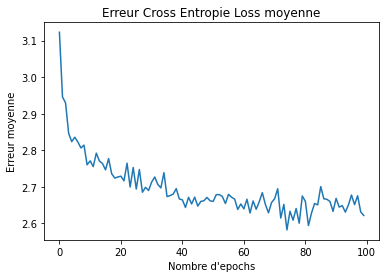

Accuracy  :  0.9136111413339136
Optimisation finie au bout de  0.5957188975811004
Train accuracy :  0.9136111413339136
Test accuracy :  0.7184564610307185


In [37]:

np.random.seed(42)
nb_classes = len(np.unique(Y_train_letters))
n_samples = X_train_letters.shape[0]

neuro_i_1 = 784
neuro_o_1 = 600
neuro_i_2 = 600
neuro_o_2 = 450
neuro_i_3 = 450
neuro_o_3 = 300
neuro_i_4 = 300
neuro_o_4 = 150
neuro_i_5 = 150
neuro_o_5 = 70
neuro_i_6 = 70
neuro_o_6 = 26


facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 100


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma)
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma)
lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma)
lineaire_4 = ModuleLineaire(neuro_i_4 ,neuro_o_4 ,plage_biais,facteur_norma)
lineaire_5 = ModuleLineaire(neuro_i_5 ,neuro_o_5 ,plage_biais,facteur_norma)
lineaire_6 = ModuleLineaire(neuro_i_6 ,neuro_o_6 ,plage_biais,facteur_norma)

TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
CE = CrossEntropieLoss(nb_classes)
softmax = SoftMax()


network_layers = [lineaire_1,TanH,lineaire_2,TanH,lineaire_3,TanH,
                  lineaire_4,TanH,lineaire_5,TanH,lineaire_6,softmax]


network = Sequentiel(network_layers)

opti = Optim(network,CE,rate_opt)
tac = time()
opti.SGD(X_train_letters,Y_train_letters,batch_size,epochs)
tic = time()

opti.affichage(X_train_letters,Y_train_letters)

net_to_graph(network, net_name="networks_images/network_MC_alphabets", horizontal=True)


print("Optimisation finie au bout de ",int((tic-tac)/60)," min")
print("Train accuracy : ",opti.getNetwork().accuracy(X_train_letters,Y_train_letters))
print("Test accuracy : ",opti.getNetwork().accuracy(X_test_letters,Y_test_letters))

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(600,450,300,150,70),activation='tanh',batch_size=100,solver='sgd')

tac = time()
mlp.fit(X_train_letters, Y_train_letters)
tic = time()

print("Optimisation finie au bout de ",int((tic-tac)/60)," min")

y_pred = mlp.predict(X_train_letters)
accuracy = accuracy_score(Y_train_letters, y_pred)
print("Train Accuracy: {:.2f}%".format(accuracy * 100))

y_pred = mlp.predict(X_test_letters)
accuracy = accuracy_score(Y_test_letters, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

# Auto-Encodeur

### Optimisation des hyperparametres de l'auto encodeur

#### Fonctions d'activation du reseau d'une maniere aleatoire

Optimisation de la dimension de l'espace latent :  2
Optimisation nb_layer  :  2


100%|███████████████████████████████████████████| 50/50 [00:16<00:00,  2.98it/s]


Optimisation nb_layer  :  3


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.93it/s]


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.97it/s]


Optimisation de la dimension de l'espace latent :  8
Optimisation nb_layer  :  2


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.94it/s]


Optimisation nb_layer  :  3


100%|███████████████████████████████████████████| 50/50 [00:26<00:00,  1.90it/s]


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.70it/s]


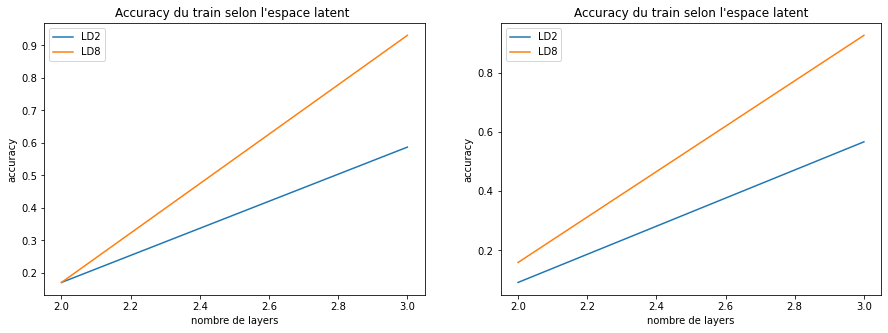

100%|███████████████████████████████████████████| 50/50 [01:08<00:00,  1.38s/it]

Auto encodeur optimal : 
Nombre layer optimal :  3
Dimension optimale de l'espace latent :  8
Fonctions d'activation prises : 
['TanH', 'Sigmoid', 'TanH']
['TanH', 'TanH', 'Sigmoid']


In [20]:
liste_layers = np.array([2,3])
liste_dim_espace_latent = np.array([2,8])
batch_size = 50
epochs = 50

auto_encodeur_optimal_rand = optimisation_network(X_train,Y_train,X_test,Y_test,
                                        liste_layers,liste_dim_espace_latent,batch_size,epochs,
                                        random_activ=True,verbose=True)


net_to_graph(network, net_name="networks_images/network_MC_alphabets", horizontal=True)


In [21]:
nb_layer_optimal = len(auto_encodeur_optimal_rand.layers_encodeur) // 2
latent_repre = auto_encodeur_optimal_rand.encode(X_train)
dim_latent_optimale = latent_repre.shape[1]

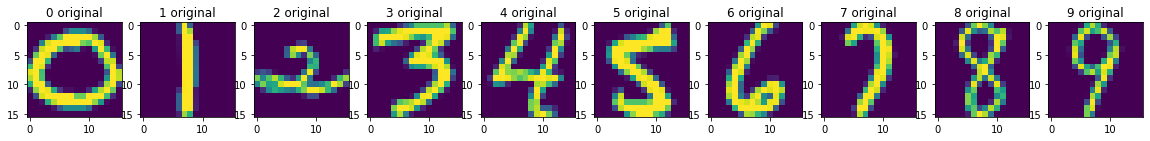

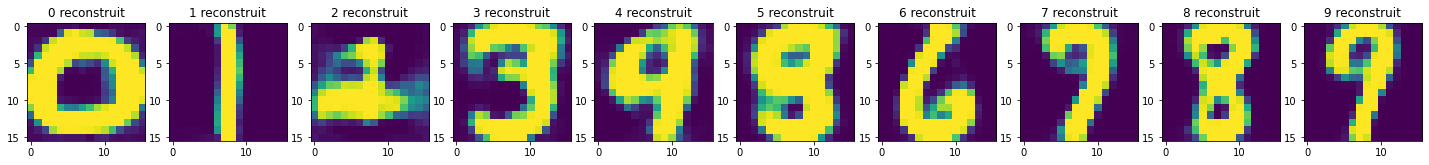

In [22]:
latent_repre = auto_encodeur_optimal_rand.encode(X_train)
X_train_hat = auto_encodeur_optimal_rand.decode(latent_repre)


plt.figure(figsize=(20,15))
sample = np.random.randint(0,100)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_train[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_train_hat[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

### Affichage des données USPS train induites de l'espace latent apres une t-SNE

#### Train

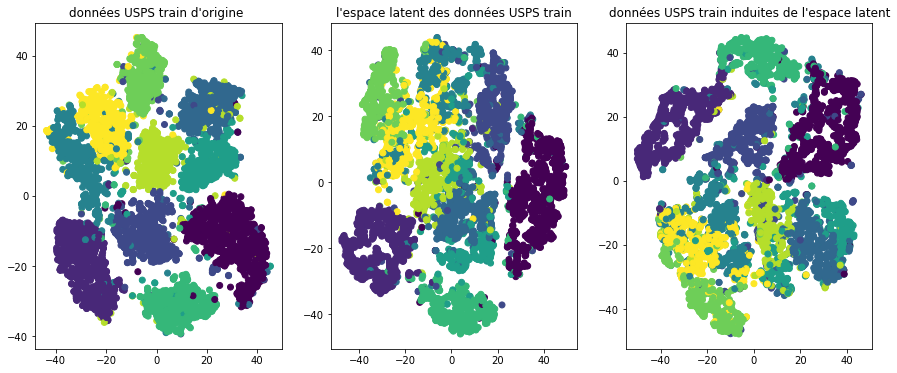

In [23]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)


fig = plt.figure(figsize=(15,6))


plt.subplot(131)
repre_2D = tsne.fit_transform(X_train)
plt.title("données USPS train d'origine ")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)

plt.subplot(132)
repre_2D = tsne.fit_transform(latent_repre)
plt.title("l'espace latent des données USPS train")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)

plt.subplot(133)
repre_2D = tsne.fit_transform(X_train_hat)
plt.title("données USPS train induites de l'espace latent")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)


plt.show()

In [8]:
kmeans = KMeans(n_clusters=10, random_state=0, max_iter=1000).fit(latent_repr)
yhat = kmeans.labels_



latent_repr = wine_auto_encodeur.encode(wine_data_norm)
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)
latent_repre_tsne = tsne.fit_transform(latent_repr)

colors = {i: plt.cm.tab10(i) for i in range(10)}

plt.subplot(121)

for c in range(10):
    plt.scatter(latent_repre_tsne[:,0][labels == c],latent_repre_tsne[:,1][labels == c],color=colors[c],label=f"classe {c}")
    
plt.title("t-SNE sur l'espace latent avec les labels d'origine")
plt.legend()


plt.subplot(122)

y_cluster_pred = np.zeros(len(latent_repr))
indices = np.arange(len(latent_repr))

for cluster in range(10):

    vals, counts = np.unique(labels[yhat == cluster], return_counts=True)
    val_maj = vals[np.argmax(counts)]
    
    y_cluster_pred[indices[yhat == cluster]] = val_maj
    
    
colors = {i: plt.cm.tab10(i) for i in range(10)}
for c in range(10):
    plt.scatter(latent_repre_tsne[:,0][y_cluster_pred == c],latent_repre_tsne[:,1][y_cluster_pred == c],color=colors[c],label=f"classe {c}")
    
plt.title("t-SNE sur l'espace latent avec les labels de kmeans")
plt.legend()
    
plt.show()

NameError: name 'latent_repr' is not defined

#### Test

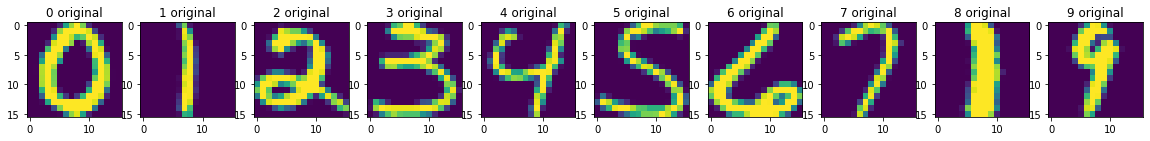

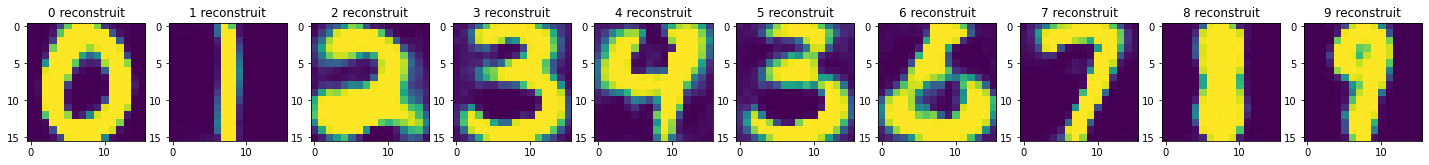

In [24]:
latent_repre_test = auto_encodeur_optimal_rand.encode(X_test)
X_test_hat = auto_encodeur_optimal_rand.decode(latent_repre_test)


plt.figure(figsize=(20,15))
sample = np.random.randint(0,100)
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_test[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_test_hat[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

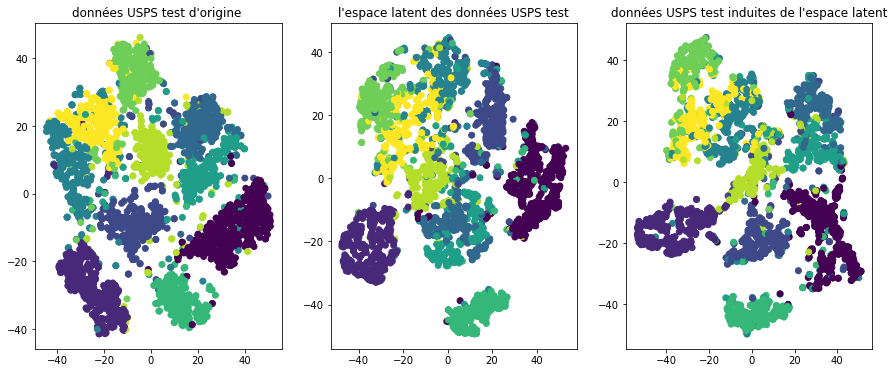

In [25]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)


fig = plt.figure(figsize=(15,6))


plt.subplot(131)
repre_2D = tsne.fit_transform(X_test)
plt.title("données USPS test d'origine ")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_test)

plt.subplot(132)
repre_2D = tsne.fit_transform(latent_repre_test)
plt.title("l'espace latent des données USPS test")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_test)

plt.subplot(133)
repre_2D = tsne.fit_transform(X_test_hat)
plt.title("données USPS test induites de l'espace latent")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_test)


plt.show()

### Evaluation de l'espace latent sur un reseau de neurones multi-classe

#### Train

In [26]:
datas = [X_train,latent_repre,X_train_hat]
evaluation(datas,Y_train,verbose=True)

Optimisation de :  X


100%|███████████████████████████████████████████| 50/50 [00:20<00:00,  2.42it/s]


Accuracy sur les images issues de l'auto encodeur 0.9982340664633167
Pureté du clustering :  0.7068550329105795
Rand score  :  0.9131695728218426
Adjusted Rand Score :  0.5448117147373678

Optimisation de :  Representation Latente


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 37.47it/s]


Accuracy sur les images issues de l'auto encodeur 0.6988280622892921
Pureté du clustering :  0.7135976882324611
Rand score  :  0.916737476198769
Adjusted Rand Score :  0.5620417535397121

Optimisation de :  X_hat


100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.77it/s]


Accuracy sur les images issues de l'auto encodeur 0.9353026167924225
Pureté du clustering :  0.7193771070797881
Rand score  :  0.917542132316027
Adjusted Rand Score :  0.5679954019045114



([0.9982340664633167, 0.6988280622892921, 0.9353026167924225],
 [0.7068550329105795, 0.7135976882324611, 0.7193771070797881],
 [0.9131695728218426, 0.916737476198769, 0.917542132316027])

#### Test

In [27]:
datas = [X_test,latent_repre_test,X_test_hat]
evaluation(datas,Y_test,verbose=True)

Optimisation de :  X


100%|███████████████████████████████████████████| 50/50 [00:10<00:00,  4.62it/s]


Accuracy sur les images issues de l'auto encodeur 0.9967416096448355
Pureté du clustering :  0.7057673509286413
Rand score  :  0.9126345679106751
Adjusted Rand Score :  0.5352113414664057

Optimisation de :  Representation Latente


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 78.25it/s]


Accuracy sur les images issues de l'auto encodeur 0.7064190289996741
Pureté du clustering :  0.7064190289996741
Rand score  :  0.914118473713881
Adjusted Rand Score :  0.5431277605888701

Optimisation de :  X_hat


100%|███████████████████████████████████████████| 50/50 [00:09<00:00,  5.09it/s]


Accuracy sur les images issues de l'auto encodeur 0.9156076898012382
Pureté du clustering :  0.7217334636689475
Rand score  :  0.9169966477238211
Adjusted Rand Score :  0.5576688761924068



([0.9967416096448355, 0.7064190289996741, 0.9156076898012382],
 [0.7057673509286413, 0.7064190289996741, 0.7217334636689475],
 [0.9126345679106751, 0.914118473713881, 0.9169966477238211])

### PCA sur l'espace latent appris par reseau

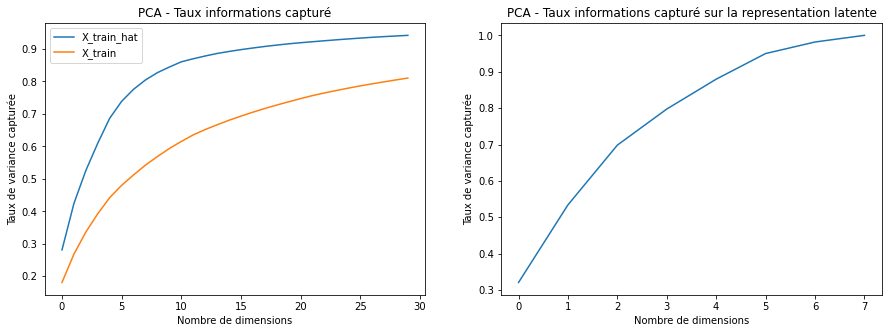

La quantité d'information moyenne perdue pendant le decodage :  0.02841758640429075


In [28]:
pca_1 = PCA(n_components=30,random_state=96)
pca_1.fit(X_train_hat)

pca_2 = PCA(n_components=30,random_state=96)
pca_2.fit(X_train)

pca_3 = PCA(n_components=dim_latent_optimale,random_state=96)
pca_3.fit(latent_repre)


plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(np.cumsum(pca_1.explained_variance_ratio_))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_))
plt.legend(["X_train_hat","X_train"])
plt.title("PCA - Taux informations capturé")
plt.xlabel("Nombre de dimensions")
plt.ylabel("Taux de variance capturée")


plt.subplot(122)
plt.plot(np.cumsum(pca_3.explained_variance_ratio_))
plt.title("PCA - Taux informations capturé sur la representation latente")
plt.xlabel("Nombre de dimensions")
plt.ylabel("Taux de variance capturée")

plt.show()

quantite_info_apres_decodage = pca_1.explained_variance_ratio_[:8]
quantite_info_espace_latent = pca_3.explained_variance_ratio_
print("La quantité d'information moyenne perdue pendant le decodage : ",
      np.abs( quantite_info_apres_decodage - quantite_info_espace_latent ).mean())

- Le taux d'informations capturé sur la representation latente converge vers un taux de 100% au bout de 6 dimensions . 
- On remarque aussi que le taux d'informations augmente plutot rapidement au fil des dimensions , ce qui veut dire que l'encodage de l'information est plutot pas mal.
- Conclusion : la dimension ideale d'arrivée de l'encodeur peut etre fixé à 6 .


- Le taux d'informations recuperé sur les données issues de l'espace latent augmente plus rapidement par rapport à celles des données de l'espace d'origine.  
- Le taux d'informations recuperé sur les données issues de l'espace latent arrivé à 100% au bout de 30 dimensions contrairement à celles des données de l'espace d'origine qui arrve uniquement à 80% de l'informations.
- Ce qui peut expliquer la condensation de la representations des données issues de l'espace latent sur une t-SNE car les exemples issues de la meme classe ont presque la meme representation (meme coordonnées) donc peut de composantes suffisent pour les representer ( la variance va etre maximal sur un nombre de composantes petit ) contrairement aux données de l'espace d'origine qui sont moins condensées c'est pour cela que un grand nombre de composantes est necessaire pour capturer le maximum d'information.
- la difference de la quantité d'informations recuperés dans l'espace latent et celle du decodage de cet espace doit etre minimale pour pouvoir dire que le decodage a pu garder l'information de l'espace latent ( l'information de l'espace d'origine reduites en dimension )  
- Un bon espace latent (regroupant le max d'informations de l'espace d'origine) permet de decoder de nouvelles images avec un pattern de chiffre parfait ( prend en compte le pattern de tous les chiffres de la classe y compris les images bruités).
- les données USPS d'origine présentent une quantité de bruit et de la redondance, ce qui peut brouiller la structure sous-jacente des données. Dans ce cas, la compression de dimension (l'encodage) aide à éliminer une partie du bruit et de la redondance, ce qui peut conduire à une PCA de meilleure qualité pour la représentation de dimension réduite.

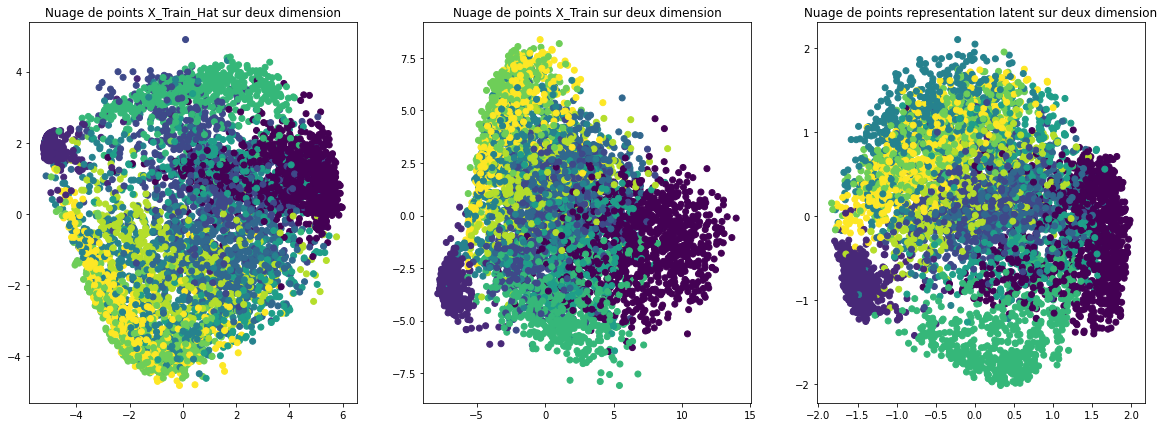

In [29]:
X_train_hat_pca = pca_1.transform(X_train_hat)
X_train_pca = pca_2.transform(X_train)
latent_repre_pca = pca_3.transform(latent_repre)

plt.figure(figsize=(20,7))

plt.subplot(131)
plt.scatter(X_train_hat_pca[:,0],X_train_hat_pca[:,1],c=Y_train)
plt.title("Nuage de points X_Train_Hat sur deux dimension")

plt.subplot(132)
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=Y_train)
plt.title("Nuage de points X_Train sur deux dimension")

plt.subplot(133)
plt.scatter(latent_repre_pca[:,0],latent_repre_pca[:,1],c=Y_train)
plt.title("Nuage de points representation latent sur deux dimension")


plt.show()

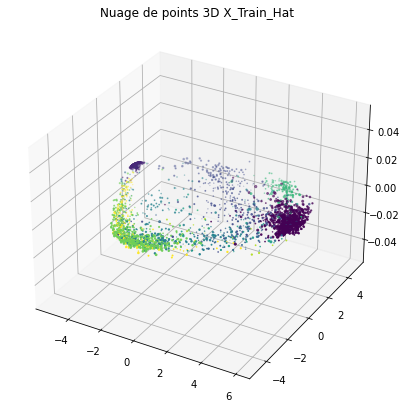

In [30]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(projection='3d')

plt.title("Nuage de points 3D X_Train_Hat")
plt.scatter(X_train_hat_pca[:,0],X_train_hat_pca[:,1],X_train_hat_pca[:,2],c=Y_train)
plt.show()

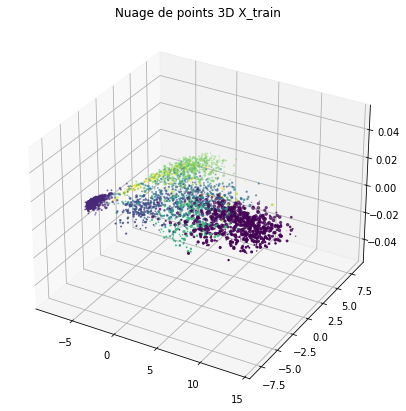

In [31]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(projection='3d')

plt.title("Nuage de points 3D X_train")
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],X_train_pca[:,2],c=Y_train)
plt.show()

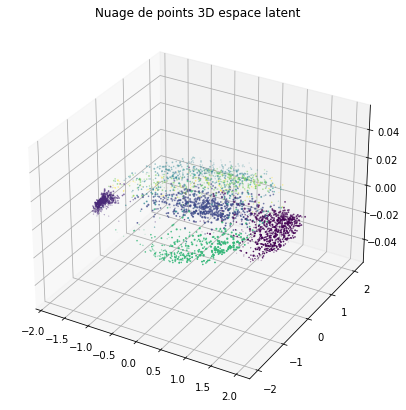

In [32]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(projection='3d')

plt.title("Nuage de points 3D espace latent")
plt.scatter(latent_repre_pca[:,0],latent_repre_pca[:,1],latent_repre_pca[:,2],c=Y_train)
plt.show()

### Impact du batch sur l'apprentissage de l'espace latent

In [33]:
shape = X_train.shape[1]
nb_layers = nb_layer_optimal
output_dim = dim_latent_optimale

size = len(auto_encodeur_optimal_rand.layers_encodeur)
auto_encodeur_optimal_rand.layers_encodeur = np.array(auto_encodeur_optimal_rand.layers_encodeur)
indices = [i for i in range(size) if i % 2 == 1 ]
activ_enc = auto_encodeur_optimal_rand.layers_encodeur[indices]

auto_encodeur_optimal_rand.layers_decodeur = np.array(auto_encodeur_optimal_rand.layers_decodeur)
indices = [i for i in range(size) if i % 2 == 1 ]
activ_dec = list(auto_encodeur_optimal_rand.layers_decodeur[indices])

activations = [ activ_enc , activ_dec]

facteur_norma = 0.8
plage_biais = (0,1)
epochs = 50
liste_batch_size = [50,300,500]
liste_auto_encodeurs = []

for batch_size in liste_batch_size:

    liste_auto_encodeurs.append(create_auto_encodeur(X_train,output_dim, nb_layers,activations, 
                                                 facteur_norma, plage_biais, batch_size, epochs,eps=1e-4))

100%|███████████████████████████████████████████| 50/50 [00:49<00:00,  1.02it/s]


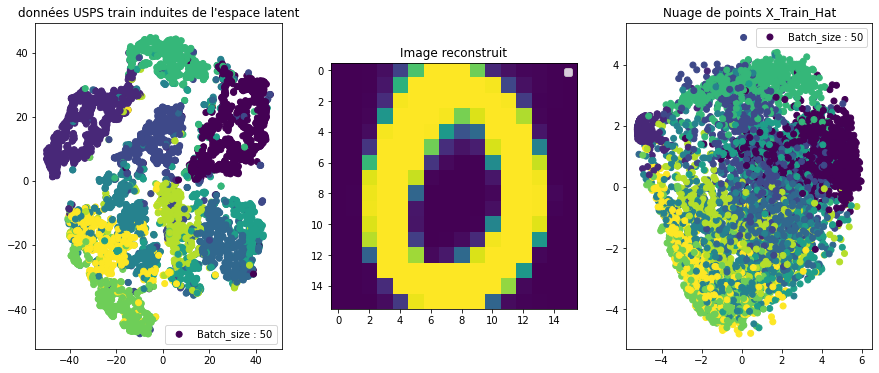

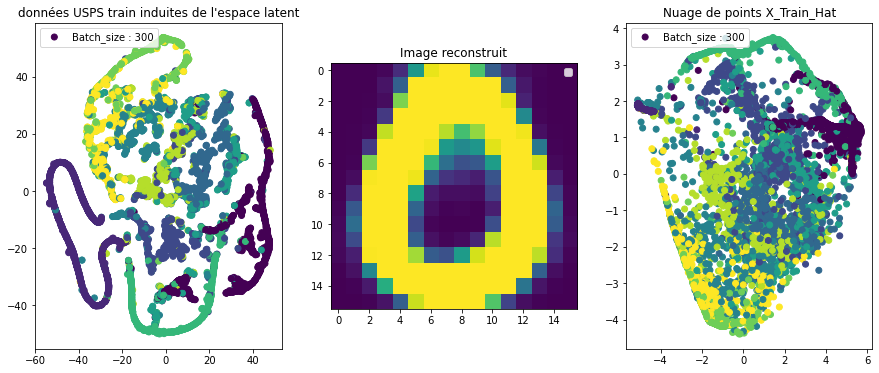

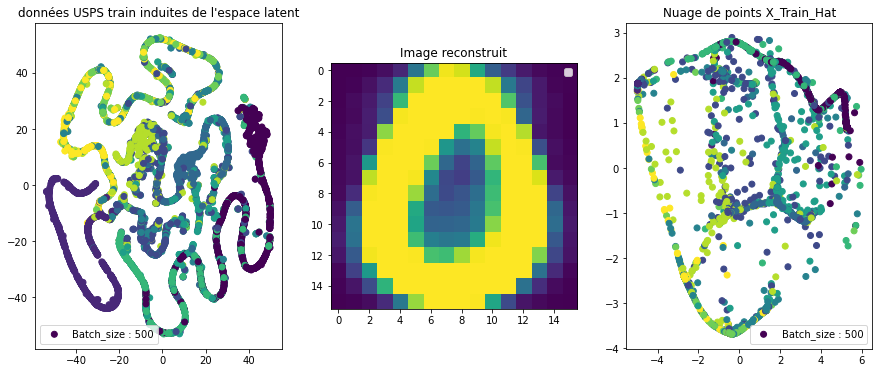

In [34]:
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)

for i,auto_encodeur in enumerate(liste_auto_encodeurs):
    
    latent_repre = auto_encodeur.encode(X_train)
    X_train_hat = auto_encodeur.decode(latent_repre)
    
    X_train_hat_pca = pca_1.transform(X_train_hat)
    

    fig = plt.figure(figsize=(15,6))


    plt.subplot(1,3,1)
    repre_2D = tsne.fit_transform(X_train_hat)
    plt.title("données USPS train induites de l'espace latent")
    plt.scatter(repre_2D[:,0],repre_2D[:,1],c=Y_train)
    plt.legend(["Batch_size : "+str(liste_batch_size[i])])
    
    plt.subplot(1,3,2)
    plt.title("Image reconstruit")
    image = X_train_hat[Y_train == 0][27].reshape((16,16))
    plt.imshow(image)
    plt.legend(["Batch_size : "+str(liste_batch_size[i])])
    
    
    plt.subplot(1,3,3)
    plt.title("Nuage de points X_Train_Hat")
    plt.scatter(X_train_hat_pca[:,0],X_train_hat_pca[:,1],c=Y_train)
    plt.legend(["Batch_size : "+str(liste_batch_size[i])])
    
    plt.show()

## Debruitage de données

#### Bruit poisson

100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.86it/s]


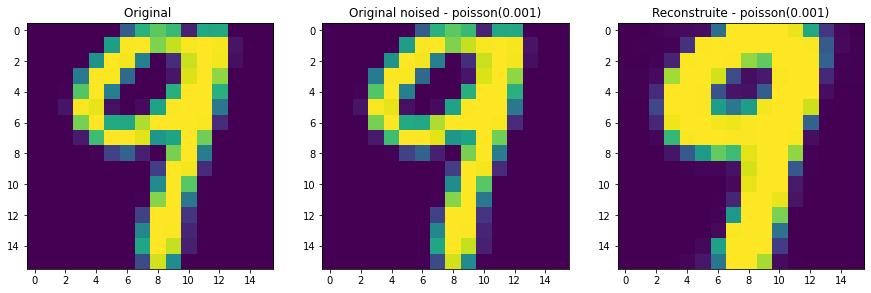

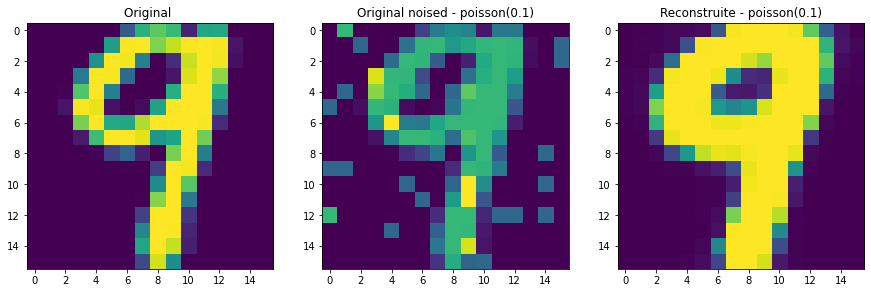

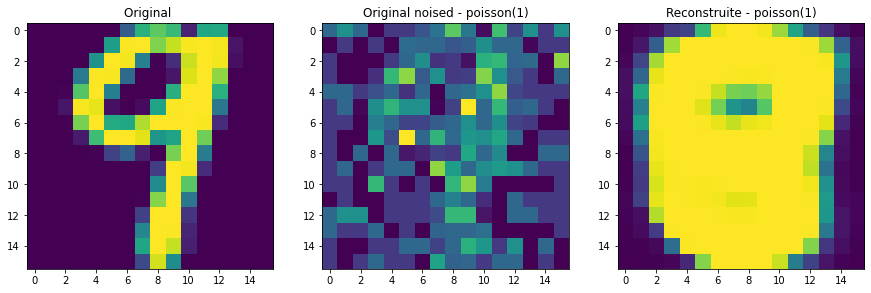

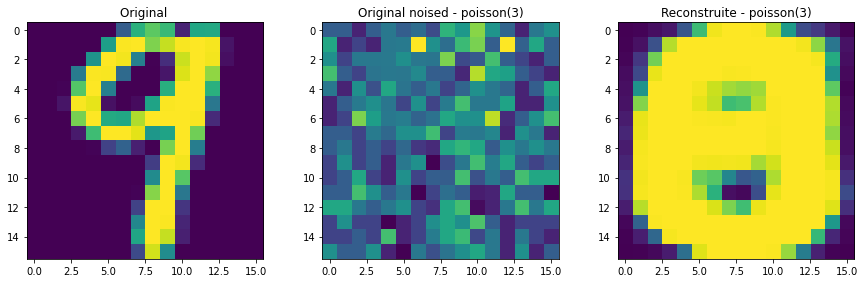

In [38]:
lamdas = [1e-3,1e-1,1,3]
scores = []

for i,lamda in enumerate(lamdas):
    noise = generate_noise(X_train.shape[1],'poisson',lamda,1e-1)
    X_train_noised = X_train + noise
    
    latent_repre_noised = auto_encodeur_optimal_rand.encode(X_train_noised)
    X_train_noised_hat = auto_encodeur_optimal_rand.decode(latent_repre_noised)
    sample = 1
    plt.figure(figsize=(15,20))

    plt.subplot(i+1,3,1)
    plt.title("Original ")
    image = X_train[sample].reshape((16,16))
    plt.imshow(image)


    plt.subplot(i+1,3,2)
    plt.title("Original noised - poisson("+str(lamda)+")")
    image = X_train_noised[sample].reshape((16,16))
    plt.imshow(image)


    plt.subplot(i+1,3,3)
    plt.title("Reconstruite - poisson("+str(lamda)+")")
    image = X_train_noised_hat[sample].reshape((16,16))
    plt.imshow(image)
    
    datas = [X_train_noised,latent_repre_noised,X_train_noised_hat]
    scores.append(evaluation(datas,Y_train,verbose=False)[0][2])
    
plt.show()

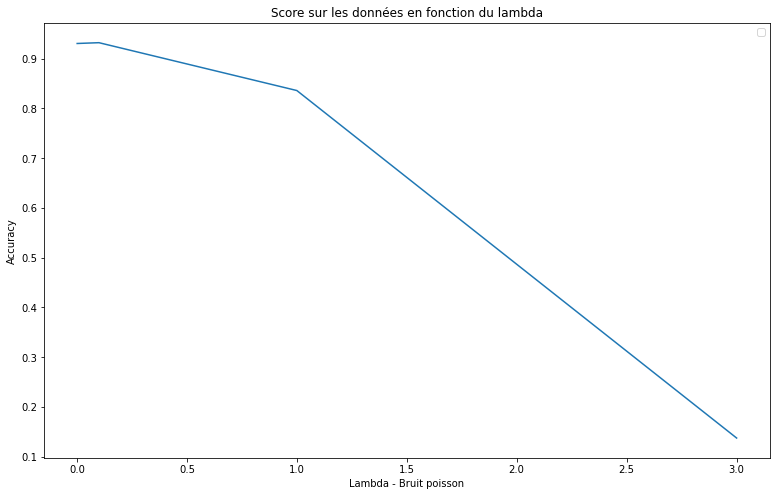

In [39]:
plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction du lambda")
plt.xlabel("Lambda - Bruit poisson")
plt.ylabel("Accuracy")
plt.legend(["Train"])
plt.plot(lamdas,scores)
plt.show()

#### Bruit gaussien

100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.93it/s]


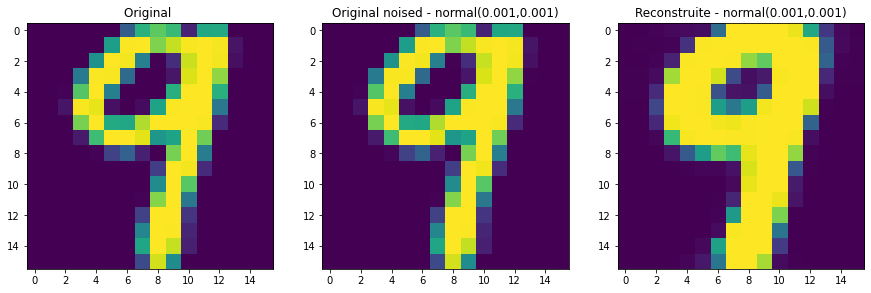

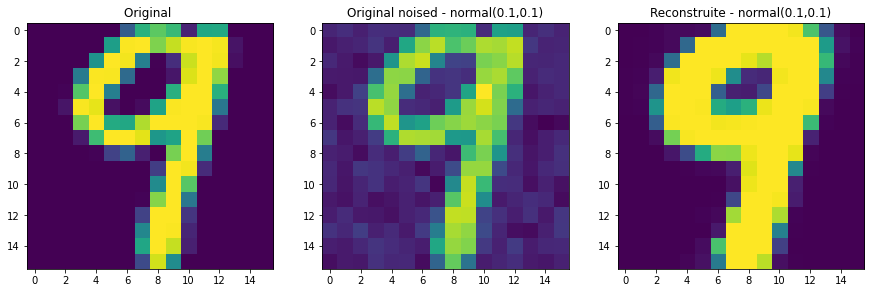

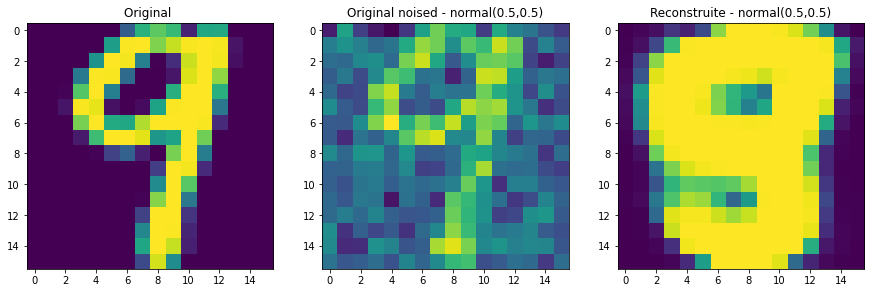

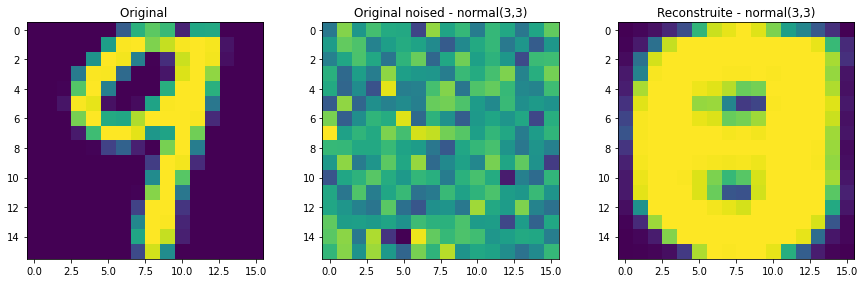

In [40]:
means = [1e-3,1e-1,0.5,3]
stds = [1e-3,1e-1,0.5,3]
scores = []


for i,mean in enumerate(means):
    noise = generate_noise(X_train.shape[1],'gaussien',mean,stds[i])
    X_train_noised = X_train + noise
    
    latent_repre_noised = auto_encodeur_optimal_rand.encode(X_train_noised)
    X_train_noised_hat = auto_encodeur_optimal_rand.decode(latent_repre_noised)
    sample = 1
    plt.figure(figsize=(15,20))

    plt.subplot(i+1,3,1)
    plt.title("Original ")
    image = X_train[sample].reshape((16,16))
    plt.imshow(image)


    plt.subplot(i+1,3,2)
    plt.title("Original noised - normal("+str(mean)+","+str(stds[i])+")")
    image = X_train_noised[sample].reshape((16,16))
    plt.imshow(image)


    plt.subplot(i+1,3,3)
    plt.title("Reconstruite - normal("+str(mean)+","+str(stds[i])+")")
    image = X_train_noised_hat[sample].reshape((16,16))
    plt.imshow(image)
    
    datas = [X_train_noised,latent_repre_noised,X_train_noised_hat]
    scores.append(evaluation(datas,Y_train,verbose=False)[0][2])
    
    
plt.show()

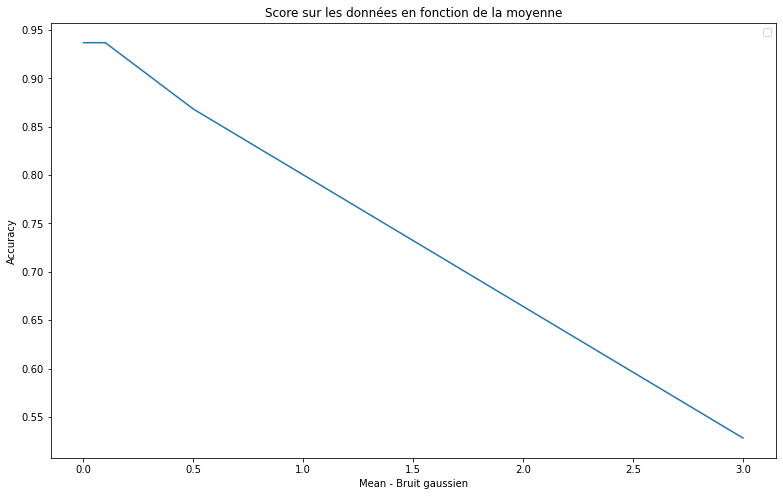

In [41]:
plt.figure(figsize=(13,8))
plt.title("Score sur les données en fonction de la moyenne")
plt.xlabel("Mean - Bruit gaussien")
plt.ylabel("Accuracy")
plt.legend(["Train"])
plt.plot(means,scores)
plt.show()

#### Train

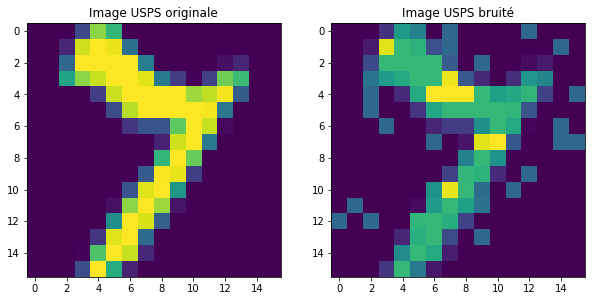

In [59]:
noise = generate_noise(X_train.shape[1],'poisson',1e-1,1e-1)
X_train_noised = X_train + noise

plt.figure(figsize=(10,6))

plt.subplot(121)
plt.title("Image USPS originale")
plt.imshow(X_train[10].reshape((16,16)))

plt.subplot(122)
plt.title("Image USPS bruité")
plt.imshow(X_train_noised[10].reshape((16,16)))
plt.show()

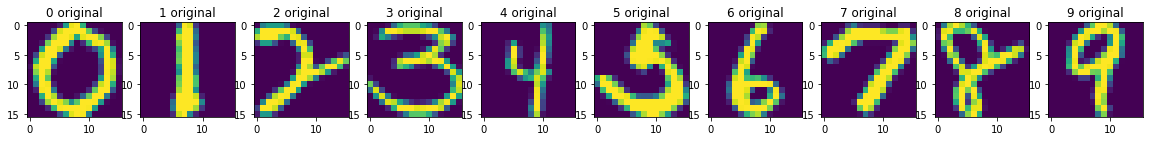

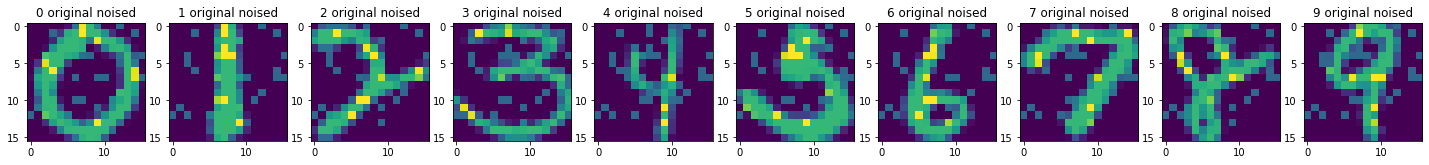

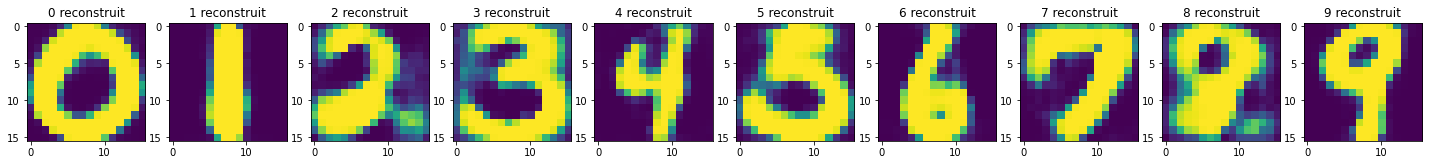

In [60]:
plt.figure(figsize=(20,15))
sample = np.random.randint(0,50)

latent_repre_noised = auto_encodeur_optimal_rand.encode(X_train_noised)
X_train_noised_hat = auto_encodeur_optimal_rand.decode(latent_repre_noised)

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_train[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original noised")
    image = X_train_noised[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_train_noised_hat[Y_train == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

In [61]:
datas = [X_train_noised,latent_repre_noised,X_train_noised_hat]
evaluation(datas,Y_train,verbose=True)

Optimisation de :  X


100%|███████████████████████████████████████████| 50/50 [00:17<00:00,  2.85it/s]


Accuracy sur les images issues de l'auto encodeur 0.9988762241130198
Pureté du clustering :  0.7068550329105795
Rand score  :  0.9131695728218426
Adjusted Rand Score :  0.5448117147373678

Optimisation de :  Representation Latente


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 41.03it/s]


Accuracy sur les images issues de l'auto encodeur 0.6851822122331033
Pureté du clustering :  0.69625943169048
Rand score  :  0.905927306887945
Adjusted Rand Score :  0.519176253681899

Optimisation de :  X_hat


100%|███████████████████████████████████████████| 50/50 [00:18<00:00,  2.75it/s]


Accuracy sur les images issues de l'auto encodeur 0.9311285920693531
Pureté du clustering :  0.693690801091668
Rand score  :  0.9129659857506579
Adjusted Rand Score :  0.5431257135605931



([0.9988762241130198, 0.6851822122331033, 0.9311285920693531],
 [0.7068550329105795, 0.69625943169048, 0.693690801091668],
 [0.9131695728218426, 0.905927306887945, 0.9129659857506579])

#### Test

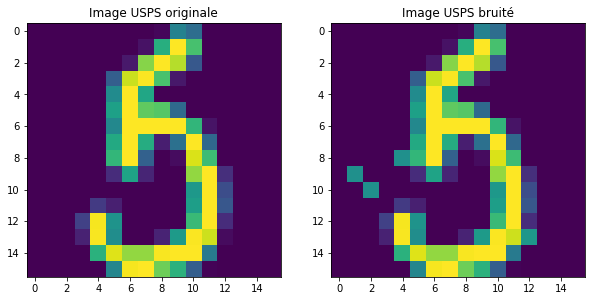

In [66]:
noise = generate_noise(X_test.shape[1],'poisson',1e-2,1e-1)
X_test_noised = X_test + noise

plt.figure(figsize=(10,6))

plt.subplot(121)
plt.title("Image USPS originale")
plt.imshow(X_test[10].reshape((16,16)))

plt.subplot(122)
plt.title("Image USPS bruité")
plt.imshow(X_test_noised[10].reshape((16,16)))
plt.show()

In [67]:
latent_repre_noised = auto_encodeur_optimal_rand.encode(X_test_noised)
X_test_noised_hat = auto_encodeur_optimal_rand.decode(latent_repre_noised)

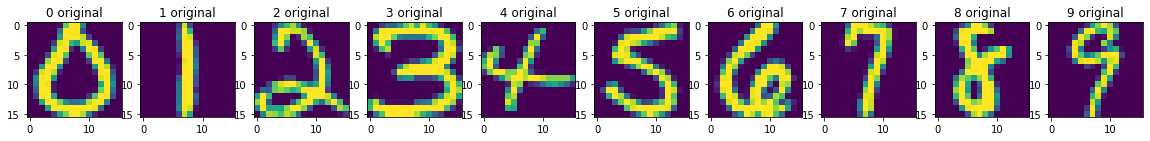

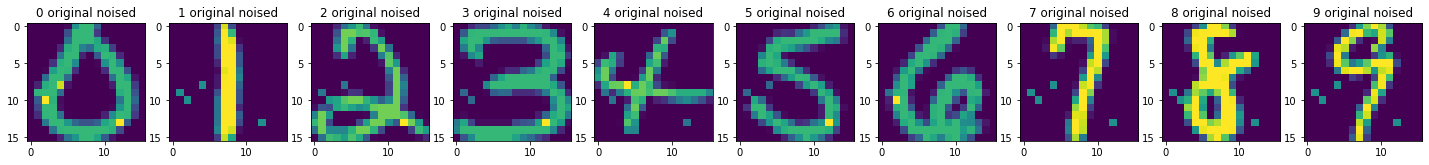

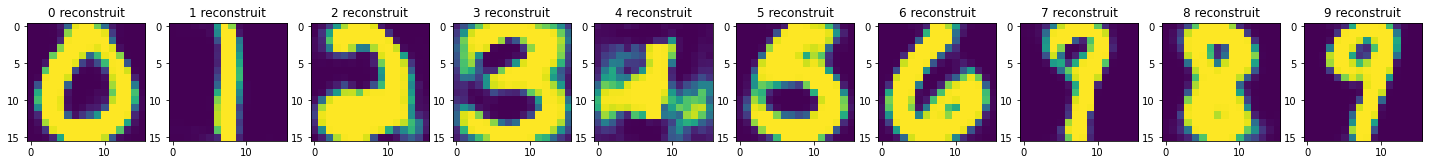

In [68]:
plt.figure(figsize=(20,15))
sample = np.random.randint(0,50)



for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original")
    image = X_test[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" original noised")
    image = X_test_noised[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

plt.figure(figsize=(25,10))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.title(str(i)+" reconstruit")
    image = X_test_noised_hat[Y_test == i][sample].reshape((16,16))
    plt.imshow(image)
plt.show()

In [48]:
datas = [X_test_noised,latent_repre_noised,X_test_noised_hat]
evaluation(datas,Y_test,verbose=True)

Optimisation de :  X


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.56it/s]


Accuracy sur les images issues de l'auto encodeur 0.996415770609319
Pureté du clustering :  0.7057673509286413
Rand score  :  0.9126345679106751
Adjusted Rand Score :  0.5352113414664057

Optimisation de :  Representation Latente


100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 55.58it/s]


Accuracy sur les images issues de l'auto encodeur 0.6663408276311502
Pureté du clustering :  0.6884978820462692
Rand score  :  0.9059589034985427
Adjusted Rand Score :  0.5086854892607517

Optimisation de :  X_hat


100%|███████████████████████████████████████████| 50/50 [00:09<00:00,  5.43it/s]


Accuracy sur les images issues de l'auto encodeur 0.9139784946236559
Pureté du clustering :  0.7135874877810362
Rand score  :  0.9156684394519277
Adjusted Rand Score :  0.549414679400056



([0.996415770609319, 0.6663408276311502, 0.9139784946236559],
 [0.7057673509286413, 0.6884978820462692, 0.7135874877810362],
 [0.9126345679106751, 0.9059589034985427, 0.9156684394519277])

## Wine et classification sur l'espace latent

In [3]:
from sklearn.datasets import load_wine
data = load_wine()
labels = data.target

wine_data_norm = normalisation(data.data)

NameError: name 'normalisation' is not defined

In [70]:
output_dim = 3
nb_layers = 2
TanH = ModuleTanH()
sig = ModuleSigmoide()
activ_enc = [TanH for _ in range(2)]
activ_dec = [TanH for _ in range(1)]
activ_dec.append(sig)

activations = [activ_enc , activ_dec]

facteur_norma = 0.8
plage_biais = (0,1)
batch_size = 50
epochs = 100


wine_auto_encodeur = create_auto_encodeur(wine_data_norm,output_dim, nb_layers,activations, 
                                                 facteur_norma, plage_biais, batch_size, epochs,eps=1e-4)


net_to_graph(wine_auto_encodeur.network, net_name="networks_images/network_AE_wine", horizontal=True)


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 604.51it/s]


Accuracy sur l'espace d'origine :  0.9887640449438202
Puerete du clustering sur l'espace d'origine:  0.949438202247191

Accuracy sur l'espace latent :  0.7921348314606742
Puerete du clustering sur l'espace latent :  0.7584269662921348


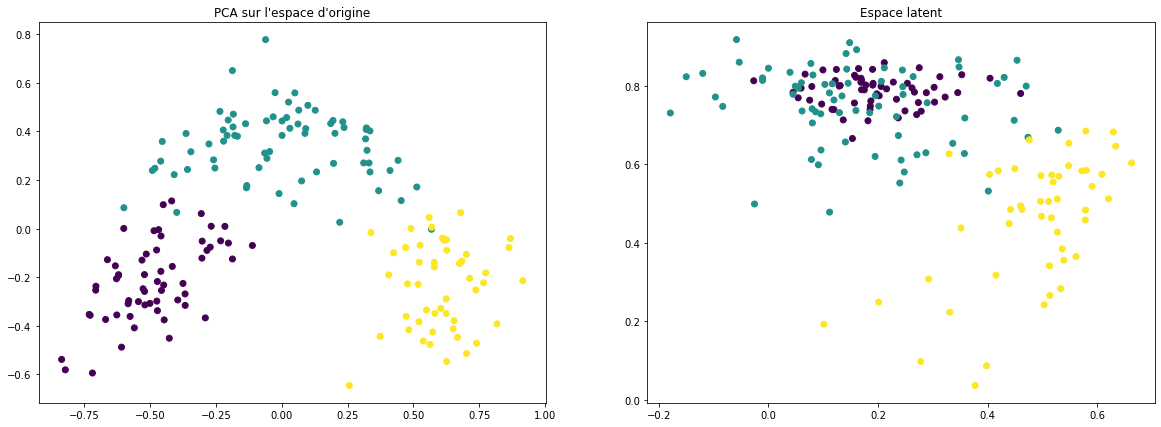

In [72]:
plt.figure(figsize=(20,7))

pca = PCA(n_components=2,random_state=96)
pca.fit(wine_data_norm)
wine_data_norm_pca = pca.transform(wine_data_norm)

plt.subplot(121)
plt.title("PCA sur l'espace d'origine")
plt.scatter(wine_data_norm_pca[:,0],wine_data_norm_pca[:,1],c=labels)

latent_repre = wine_auto_encodeur.encode(wine_data_norm)
plt.subplot(122)
plt.title("Espace latent")
plt.scatter(latent_repre[:,0],latent_repre[:,1],c=labels)


latent_repre = wine_auto_encodeur.encode(wine_data_norm)


clf = LogisticRegression(random_state=0).fit(wine_data_norm,labels)
print("Accuracy sur l'espace d'origine : ",clf.score(wine_data_norm,labels))
kmeans = KMeans(n_clusters=3, random_state=0, max_iter=100).fit(wine_data_norm)
yhat = kmeans.labels_

print("Puerete du clustering sur l'espace d'origine: ",cluster_purity(yhat,labels))
print()

clf = LogisticRegression(random_state=0).fit(latent_repre,labels)
print("Accuracy sur l'espace latent : ",clf.score(latent_repre,labels))
kmeans = KMeans(n_clusters=3, random_state=0, max_iter=100).fit(latent_repre)
yhat = kmeans.labels_

print("Puerete du clustering sur l'espace latent : ",cluster_purity(yhat,labels))

## Credit Card et clustering sur l'espace latente

In [73]:
cc_data = pd.read_csv("data/CC GENERAL.csv")

In [74]:
cc_data.describe()

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083333   
50%                 89.000000      0.000000             0.500000   
75%                468.637500   1113.821139             0.916667   
max              22500.000000  47137.211760             1.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8950.000000                       8950.000000   
mean                     0.202458                          0.364437   
std                      0.298336                          0.397448   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083333                          0.166667   
75%                      0.300000                          0.750000   
max                      1.000000                          1.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8950.000000       8950.000000    8950.000000   8949.000000   
mean                 0.135144          3.248827      14.709832   4494.449450   
std                  0.200121          6.824647      24.857649   3638.815725   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.222222          4.000000      17.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count   8950.000000       8637.000000       8950.000000  8950.000000  
mean    1733.143852        864.206542          0.153715    11.517318  
std     2895.063757       2372.446607          0.292499     1.338331  
min        0.000000          0.019163          0.000000     6.000000  
25%      383.276166        169.123707          0.000000    12.000000  
50%      856.901546        312.343947          0.000000    12.000000  
75%     1901.134317        825.485459          0.142857    12.000000  
max    50721.483360      76406.207520          1.000000    12.000000

In [75]:
# supprimer les valeurs NaN
cc_data = cc_data.dropna()

cc_data = np.array(cc_data)
# supprimer la colonne 1
cc_data = cc_data[:,1:]
cc_data = cc_data.astype('float')
y = np.random.randint(0,1,cc_data.shape[0])

data_norm = normalisation(cc_data)

data_norm = data_norm.astype('float')

In [76]:
shape = data_norm.shape[1]
nb_layers = 2
output_dim = 7

TanH = ModuleTanH()
sig = ModuleSigmoide()
activ_enc = [TanH for _ in range(nb_layers)]
activ_dec = [TanH for _ in range(nb_layers - 1)]
activ_dec.append(sig)

activations = [activ_enc , activ_dec]


facteur_norma = 0.8
plage_biais = (0,1)
batch_size = 50
epochs = 50

auto_encodeur_cc_optimal= create_auto_encodeur(data_norm,output_dim, nb_layers,activations, 
                                                 facteur_norma, plage_biais, batch_size, epochs,eps=1e-4)

net_to_graph(auto_encodeur_cc_optimal.network, net_name="networks_images/network_AE_credit_card", horizontal=True)



100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 13.59it/s]


In [77]:
latent_repre = auto_encodeur_cc_optimal.encode(data_norm)
data_norm_hat = auto_encodeur_cc_optimal.decode(latent_repre)

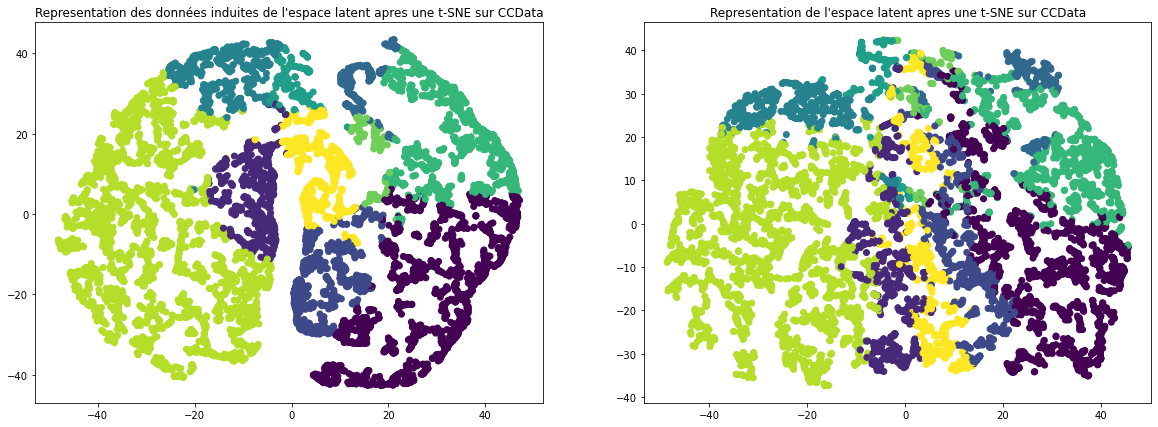

In [78]:
kmeans = KMeans(n_clusters=10, random_state=0, max_iter=100).fit(data_norm_hat)

plt.figure(figsize=(20,7))

yhat = kmeans.labels_

plt.subplot(121)
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)
repre_2D = tsne.fit_transform(data_norm_hat)

plt.title("Representation des données induites de l'espace latent apres une t-SNE sur CCData")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=yhat)

plt.subplot(122)
tsne = TSNE(n_components=2, init='pca',n_iter=500, verbose=0)
repre_2D = tsne.fit_transform(latent_repre)

plt.title("Representation de l'espace latent apres une t-SNE sur CCData")
plt.scatter(repre_2D[:,0],repre_2D[:,1],c=yhat)

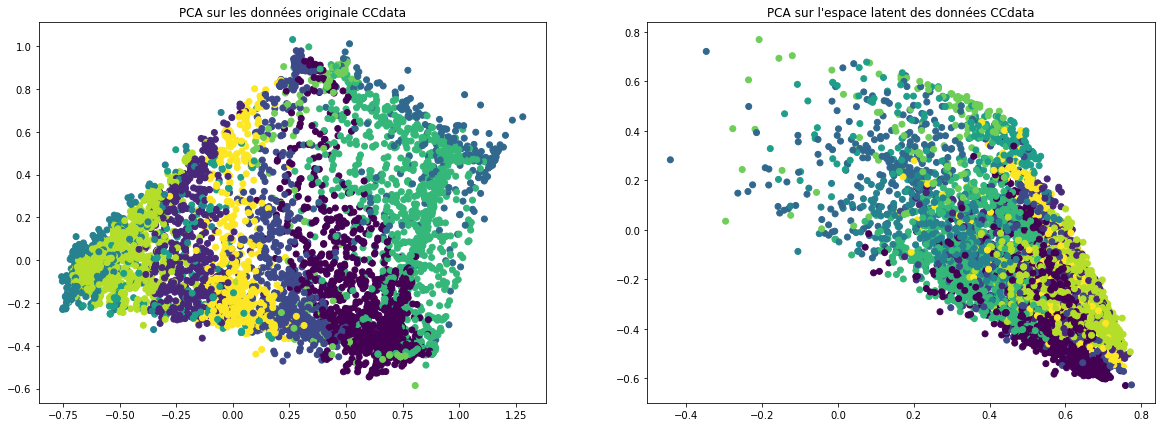

In [79]:
pca = PCA(n_components=17,random_state=96)
pca.fit(data_norm)
X_train_pca = pca.transform(data_norm)


plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=yhat)
plt.title("PCA sur les données originale CCdata")

plt.subplot(1,2,2)
plt.title("PCA sur l'espace latent des données CCdata")
plt.scatter(latent_repre[:,0],latent_repre[:,1],c=yhat)

In [121]:
dt = pd.read_csv("data/pokemon_alopez247.csv")
dt.describe()

Number       Total          HP      Attack     Defense      Sp_Atk  \
count  721.00000  721.000000  721.000000  721.000000  721.000000  721.000000   
mean   361.00000  417.945908   68.380028   75.013870   70.808599   68.737864   
std    208.27906  109.663671   25.848272   28.984475   29.296558   28.788005   
min      1.00000  180.000000    1.000000    5.000000    5.000000   10.000000   
25%    181.00000  320.000000   50.000000   53.000000   50.000000   45.000000   
50%    361.00000  424.000000   65.000000   74.000000   65.000000   65.000000   
75%    541.00000  499.000000   80.000000   95.000000   85.000000   90.000000   
max    721.00000  720.000000  255.000000  165.000000  230.000000  154.000000   

           Sp_Def       Speed  Generation     Pr_Male    Height_m   Weight_kg  \
count  721.000000  721.000000  721.000000  644.000000  721.000000  721.000000   
mean    69.291262   65.714286    3.323162    0.553377    1.144979   56.773370   
std     27.015860   27.277920    1.669873    0.199969    1.044369   89.095667   
min     20.000000    5.000000    1.000000    0.000000    0.100000    0.100000   
25%     50.000000   45.000000    2.000000    0.500000    0.610000    9.400000   
50%     65.000000   65.000000    3.000000    0.500000    0.990000   28.000000   
75%     85.000000   85.000000    5.000000    0.500000    1.400000   61.000000   
max    230.000000  160.000000    6.000000    1.000000   14.500000  950.000000   

       Catch_Rate  
count  721.000000  
mean   100.246879  
std     76.573513  
min      3.000000  
25%     45.000000  
50%     65.000000  
75%    180.000000  
max    255.000000

In [122]:
dt.head()

Number        Name Type_1  Type_2  Total  HP  Attack  Defense  Sp_Atk  \
0       1   Bulbasaur  Grass  Poison    318  45      49       49      65   
1       2     Ivysaur  Grass  Poison    405  60      62       63      80   
2       3    Venusaur  Grass  Poison    525  80      82       83     100   
3       4  Charmander   Fire     NaN    309  39      52       43      60   
4       5  Charmeleon   Fire     NaN    405  58      64       58      80   

   Sp_Def  ...  Color  hasGender  Pr_Male Egg_Group_1  Egg_Group_2  \
0      65  ...  Green       True    0.875     Monster        Grass   
1      80  ...  Green       True    0.875     Monster        Grass   
2     100  ...  Green       True    0.875     Monster        Grass   
3      50  ...    Red       True    0.875     Monster       Dragon   
4      65  ...    Red       True    0.875     Monster       Dragon   

   hasMegaEvolution Height_m Weight_kg  Catch_Rate      Body_Style  
0             False     0.71       6.9          45       quadruped  
1             False     0.99      13.0          45       quadruped  
2              True     2.01     100.0          45       quadruped  
3             False     0.61       8.5          45  bipedal_tailed  
4             False     1.09      19.0          45  bipedal_tailed  

[5 rows x 23 columns]

In [128]:
dt.columns

Index(['Number', 'Name', 'Type_1', 'Type_2', 'Total', 'HP', 'Attack',
       'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'Generation', 'isLegendary',
       'Color', 'hasGender', 'Pr_Male', 'Egg_Group_1', 'Egg_Group_2',
       'hasMegaEvolution', 'Height_m', 'Weight_kg', 'Catch_Rate',
       'Body_Style'],
      dtype='object')

In [136]:
np.unique(dt["Body_Style"],return_counts=True)

(array(['bipedal_tailed', 'bipedal_tailless', 'four_wings', 'head_arms',
        'head_base', 'head_legs', 'head_only', 'insectoid',
        'multiple_bodies', 'quadruped', 'serpentine_body', 'several_limbs',
        'two_wings', 'with_fins'], dtype=object),
 array([158, 109,  18,  39,  30,  17,  34,  30,  15, 135,  29,  13,  63,
         31]))

In [97]:
dt.drop(['Number','Name','Type_2','Pr_Male','Egg_Group_2'],axis=1,inplace=True)

In [103]:
dt = pd.get_dummies(dt)

In [104]:
dt.head()

Total  HP  Attack  Defense  Sp_Atk  Sp_Def  Speed  Generation  isLegendary  \
0    318  45      49       49      65      65     45           1        False   
1    405  60      62       63      80      80     60           1        False   
2    525  80      82       83     100     100     80           1        False   
3    309  39      52       43      60      50     65           1        False   
4    405  58      64       58      80      65     80           1        False   

   hasGender  ...  Body_Style_head_base  Body_Style_head_legs  \
0       True  ...                     0                     0   
1       True  ...                     0                     0   
2       True  ...                     0                     0   
3       True  ...                     0                     0   
4       True  ...                     0                     0   

   Body_Style_head_only  Body_Style_insectoid  Body_Style_multiple_bodies  \
0                     0                     0                           0   
1                     0                     0                           0   
2                     0                     0                           0   
3                     0                     0                           0   
4                     0                     0                           0   

   Body_Style_quadruped  Body_Style_serpentine_body  Body_Style_several_limbs  \
0                     1                           0                         0   
1                     1                           0                         0   
2                     1                           0                         0   
3                     0                           0                         0   
4                     0                           0                         0   

   Body_Style_two_wings  Body_Style_with_fins  
0                     0                     0  
1                     0                     0  
2                     0                     0  
3                     0                     0  
4                     0                     0  

[5 rows x 71 columns]

In [113]:
str_cols = dt.select_dtypes(include='bool')
print(str_cols)

     isLegendary  hasGender  hasMegaEvolution
0          False       True             False
1          False       True             False
2          False       True              True
3          False       True             False
4          False       True             False
..           ...        ...               ...
716         True      False             False
717         True      False             False
718         True      False              True
719         True      False             False
720         True      False             False

[721 rows x 3 columns]


In [119]:
cols = ["isLegendary","hasGender","hasMegaEvolution"]
for col in cols:
    dt[col] = dt[col].astype('int')

In [120]:
dt.head()

Total  HP  Attack  Defense  Sp_Atk  Sp_Def  Speed  Generation  isLegendary  \
0    318  45      49       49      65      65     45           1            0   
1    405  60      62       63      80      80     60           1            0   
2    525  80      82       83     100     100     80           1            0   
3    309  39      52       43      60      50     65           1            0   
4    405  58      64       58      80      65     80           1            0   

   hasGender  ...  Body_Style_head_base  Body_Style_head_legs  \
0          1  ...                     0                     0   
1          1  ...                     0                     0   
2          1  ...                     0                     0   
3          1  ...                     0                     0   
4          1  ...                     0                     0   

   Body_Style_head_only  Body_Style_insectoid  Body_Style_multiple_bodies  \
0                     0                     0                           0   
1                     0                     0                           0   
2                     0                     0                           0   
3                     0                     0                           0   
4                     0                     0                           0   

   Body_Style_quadruped  Body_Style_serpentine_body  Body_Style_several_limbs  \
0                     1                           0                         0   
1                     1                           0                         0   
2                     1                           0                         0   
3                     0                           0                         0   
4                     0                           0                         0   

   Body_Style_two_wings  Body_Style_with_fins  
0                     0                     0  
1                     0                     0  
2                     0                     0  
3                     0                     0  
4                     0                     0  

[5 rows x 71 columns]

100%|█████████████████████████████████████████| 100/100 [05:17<00:00,  3.17s/it]


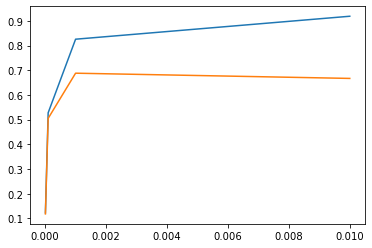

Learning rate optimal :  0.01


 57%|███████████████████████▉                  | 57/100 [03:24<02:34,  3.60s/it]


KeyboardInterrupt: 

Train Accuracy: 95.54%
Test Accuracy: 67.86%


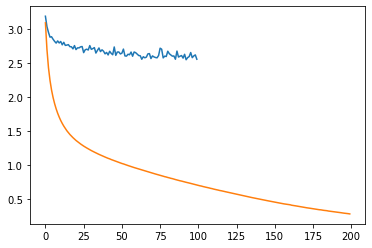

In [23]:
plt.plot(np.arange(len(opti.losses)),opti.losses)
plt.plot(np.arange(len(mlp.loss_curve_)),mlp.loss_curve_)   
plt.show()